### Training Notebook

Author: Antony Sikorski

In this notebook we do a little bit of setup, train the model, and take a look at the loss. 

If you get any package error, install the requirements please: 

In [1]:
#!pip install -r requirements.txt

In [2]:
# libraries 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
import json
from collections import Counter, defaultdict
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from jaxtyping import Int, Float
import tqdm
import transformers
import transformer_lens
from muutils.misc import shorten_numerical_to_str

#imports from files
from text_dataset import TextDataset
from model import GPTConfig, GPT

c:\Python\Python_3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python\Python_3_10\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Let's check if you have a GPU on your computer that you can run this on. That could make this process significantly faster, but you could also run out of memory (Cuda Out Of Memory error). If you don't have torch with CUDA, don't worry about this, you can just use your CPU. 

In [3]:
if(torch.cuda.is_available() == True):
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3060 Laptop GPU


I can use my laptop GPU, which is good news! 

In [4]:
# necessary auto-reload for development on local machine
%load_ext autoreload
%autoreload 2

### DataSet

Let's use the TinyStories dataset, a well known dataset that gained fame when small yet still coherent models were trained on it. The dataset is made from a bunch of GPT generated children's stories, thus it does not have much diversity in content and should theoretically be pretty easy to learn. 

We only use a small chunk of the data for the sake of making training easy on a laptop. 

In [5]:
# grabbing the whole dataset
text_data = load_dataset("roneneldan/TinyStories")

Repo card metadata block was not found. Setting CardData to empty.


In [6]:
#let's only use the training data
text_data = text_data["train"]

# and let's only use the first story_num stories 
story_num = 40000
text_data = text_data[:story_num]

#what does a story look like? 
print("\n Sample story (story #8):")
text_data['text'][7]


 Sample story (story #8):


'Once upon a time, in a peaceful town, there lived a little boy named Tim. Tim loved to run and play outside. One day, Tim saw a race in the park. He was excited and wanted to join the race.\n\nTim went to his friend, Sarah, and said, "Let\'s start the race!" Sarah smiled and said, "Yes, let\'s go!" They lined up with the other kids and waited for the race to begin. When they heard the word "Go!", they started running as fast as they could.\n\nTim and Sarah ran with all their speed, laughing and having fun. They could feel the wind in their hair as they raced to the finish line. In the end, Tim won the race and Sarah came in second. They were both so happy and proud of themselves. They celebrated with their friends and had a great day at the park.'

Okay now let's turn our dataset into a big long string, and check how long it is: 

In [7]:
text_data = "\n\n".join(text_data['text'])
len(text_data)

#1,904,212,639
#8,694,759
#88,506,738

36049831

### Training 

Here we train the model! First, we define our training loop. Our dataset is saved on the CPU, but everything else will be on GPU. We will move our batches from CPU to GPU. This slows things down, but is worth the extra compute because it enables us to use more data.  

In [8]:
def train(
	model: GPT,
	text: str,
	optimizer: torch.optim.Optimizer,
	scheduler: torch.optim.lr_scheduler._LRScheduler,
	device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size: int = 8,
	max_batches: int|None = None,
	print_interval: int = 100,
	epochs: int = 1,
) -> tuple[GPT, list[dict]]:
	
	# move model to device
	print(f"moving model to device: {device}")
	model.to(device)
	
	# set up data
	print(f"setting up dataset from text of length {len(text)}")
	dataset: TextDataset = TextDataset(
		text=text, 
		tokenizer=model.tokenizer, 
		n_context=model.config.n_context,
	)
	print(f"\tset up dataset with {len(dataset)} examples, example lengths: {dataset.example_lengths()}")

	print(f"setting up dataloader from {len(dataset)} examples")
	dataloader: DataLoader = DataLoader(
		dataset, 
		batch_size=batch_size, 
		shuffle=True,
		pin_memory=True,
	)
	print(f"\tset up dataloader with {len(dataloader)} batches of size {batch_size}")

	# set up training loop
	print("training...")
	training_records: list[dict] = list()
	model.train()

	for epoch in range(epochs):
		print(f"Epoch {epoch + 1}/{epochs}\n")
		i: int; batch: Float[torch.Tensor, "batch n_ctx"]
		for i, batch in tqdm.tqdm(
			enumerate(dataloader),
			total=len(dataloader),
			desc="Training",
		):
			# move batch to device
			batch = batch.to(device)
			
			# break if we've reached the maximum number of batches
			if max_batches is not None and i > max_batches:
				break

			# forward pass
			logits, loss = model(
				batch[:, :-1],
				targets=batch[:, 1:], # the targets are just the input, offset by one
			)

			# backward pass
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# record progress
			training_records.append({
				"batch": i,
				"loss": loss.item(),
			})

			if i % print_interval == 0:
				print(f"Batch {i}, Loss: {loss.item()}\n")

		scheduler.step()
		print(f"Updated learning rate to: {optimizer.param_groups[0]['lr']}")

	return model, training_records

Now let's configure (define params for) our own model (which will be small) and do some setup before we train it: 

In [9]:
# using the GPT2 tokenizer, and making sure it has the same vocab size as the model
TOKENIZER: transformers.PreTrainedTokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
print(f"{TOKENIZER.vocab_size = } \n")


# set up a config for a small model
CONFIG: GPTConfig = GPTConfig(
	d_model=16,
	d_vocab=50257,
	n_context=128,
	n_blocks=2,
	n_head=4,
    tokenizer=TOKENIZER,
)

# not the most necessary check but it felt good to do
assert(TOKENIZER.vocab_size == GPTConfig().d_vocab)

# initialize the model
MODEL: GPT = GPT(CONFIG)

#two ways of printing number of model params
print("Muutils rounded model params: ")
print(f"MODEL.n_params = {shorten_numerical_to_str(MODEL.n_params)} \n")
print("Full model params: ")
print(f"MODEL.n_params = {MODEL.n_params}")

# choice of optimizer
OPTIMIZER: torch.optim.Optimizer = torch.optim.AdamW(MODEL.parameters(), lr=1e-2)
#OPTIMIZER: torch.optim.Optimizer = torch.optim.SGD(MODEL.parameters(), lr=1e-1)
# Initialize the learning rate scheduler
SCHEDULER: StepLR = StepLR(OPTIMIZER, step_size=3, gamma=0.2)

TOKENIZER.vocab_size = 50257 

Muutils rounded model params: 
MODEL.n_params = 1.6M 

Full model params: 
MODEL.n_params = 1616864


In [10]:
print(TOKENIZER)

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


Let's train the model! 

In [11]:
MODEL_TRAINED, training_history = train(
	model=MODEL,
	text=text_data,
	optimizer=OPTIMIZER,
    scheduler = SCHEDULER,
	device=("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size=10,
	max_batches=None,
	print_interval=100,
	epochs= 10,
)


moving model to device: cuda
setting up dataset from text of length 36049831


Token indices sequence length is longer than the specified maximum sequence length for this model (9007886 > 1024). Running this sequence through the model will result in indexing errors


	set up dataset with 69828 examples, example lengths: Counter({129: 69828})
setting up dataloader from 69828 examples
	set up dataloader with 6983 batches of size 10
training...
Epoch 1/10



Training:   0%|          | 2/6983 [00:02<1:57:53,  1.01s/it]

Batch 0, Loss: 10.926478385925293



Training:   1%|▏         | 102/6983 [00:13<12:46,  8.98it/s]

Batch 100, Loss: 5.374959945678711



Training:   3%|▎         | 202/6983 [00:24<12:42,  8.89it/s]

Batch 200, Loss: 4.615973949432373



Training:   4%|▍         | 302/6983 [00:36<12:14,  9.09it/s]

Batch 300, Loss: 4.353177547454834



Training:   6%|▌         | 402/6983 [00:47<11:36,  9.44it/s]

Batch 400, Loss: 4.24783992767334



Training:   7%|▋         | 502/6983 [00:57<11:19,  9.53it/s]

Batch 500, Loss: 4.300217151641846



Training:   9%|▊         | 602/6983 [01:08<11:13,  9.48it/s]

Batch 600, Loss: 4.144784450531006



Training:  10%|█         | 702/6983 [01:18<11:24,  9.18it/s]

Batch 700, Loss: 4.124286651611328



Training:  11%|█▏        | 802/6983 [01:30<12:14,  8.42it/s]

Batch 800, Loss: 4.308272838592529



Training:  13%|█▎        | 902/6983 [01:46<46:11,  2.19it/s]  

Batch 900, Loss: 3.8855502605438232



Training:  14%|█▍        | 1002/6983 [02:13<13:15,  7.52it/s] 

Batch 1000, Loss: 4.007823944091797



Training:  16%|█▌        | 1102/6983 [02:29<17:46,  5.51it/s]

Batch 1100, Loss: 3.858254909515381



Training:  17%|█▋        | 1202/6983 [02:40<10:54,  8.83it/s]

Batch 1200, Loss: 4.103630065917969



Training:  19%|█▊        | 1302/6983 [02:51<10:08,  9.33it/s]

Batch 1300, Loss: 3.8977229595184326



Training:  20%|██        | 1402/6983 [03:02<10:00,  9.30it/s]

Batch 1400, Loss: 3.9603378772735596



Training:  22%|██▏       | 1502/6983 [03:14<09:50,  9.28it/s]

Batch 1500, Loss: 3.634960174560547



Training:  23%|██▎       | 1601/6983 [03:30<22:20,  4.02it/s]

Batch 1600, Loss: 3.8554911613464355



Training:  24%|██▍       | 1701/6983 [03:45<47:28,  1.85it/s]

Batch 1700, Loss: 3.894960880279541



Training:  26%|██▌       | 1802/6983 [03:59<09:41,  8.90it/s]

Batch 1800, Loss: 3.99882173538208



Training:  27%|██▋       | 1902/6983 [04:11<09:48,  8.64it/s]

Batch 1900, Loss: 3.7410645484924316



Training:  29%|██▊       | 2002/6983 [04:22<09:51,  8.42it/s]

Batch 2000, Loss: 3.6704788208007812



Training:  30%|███       | 2101/6983 [04:34<09:05,  8.95it/s]

Batch 2100, Loss: 3.693403720855713



Training:  32%|███▏      | 2202/6983 [04:50<09:11,  8.67it/s]

Batch 2200, Loss: 3.7415366172790527



Training:  33%|███▎      | 2302/6983 [05:02<09:05,  8.58it/s]

Batch 2300, Loss: 3.423224687576294



Training:  34%|███▍      | 2402/6983 [05:16<08:44,  8.74it/s]

Batch 2400, Loss: 3.6256237030029297



Training:  36%|███▌      | 2502/6983 [05:30<09:20,  8.00it/s]

Batch 2500, Loss: 3.764220714569092



Training:  37%|███▋      | 2602/6983 [05:46<08:49,  8.28it/s]

Batch 2600, Loss: 3.896061658859253



Training:  39%|███▊      | 2702/6983 [05:57<07:49,  9.12it/s]

Batch 2700, Loss: 3.376948595046997



Training:  40%|████      | 2802/6983 [06:09<09:33,  7.29it/s]

Batch 2800, Loss: 3.6301398277282715



Training:  42%|████▏     | 2902/6983 [06:25<07:16,  9.36it/s]

Batch 2900, Loss: 3.544658660888672



Training:  43%|████▎     | 3002/6983 [06:38<08:20,  7.96it/s]

Batch 3000, Loss: 3.545228958129883



Training:  44%|████▍     | 3102/6983 [06:50<08:01,  8.05it/s]

Batch 3100, Loss: 3.6056084632873535



Training:  46%|████▌     | 3202/6983 [07:02<08:23,  7.51it/s]

Batch 3200, Loss: 3.55900502204895



Training:  47%|████▋     | 3302/6983 [07:15<07:45,  7.91it/s]

Batch 3300, Loss: 3.592276096343994



Training:  49%|████▊     | 3402/6983 [07:36<06:45,  8.83it/s]

Batch 3400, Loss: 3.4629745483398438



Training:  50%|█████     | 3502/6983 [07:53<14:43,  3.94it/s]

Batch 3500, Loss: 3.8140997886657715



Training:  52%|█████▏    | 3602/6983 [08:05<06:20,  8.88it/s]

Batch 3600, Loss: 3.940542221069336



Training:  53%|█████▎    | 3702/6983 [08:17<06:21,  8.61it/s]

Batch 3700, Loss: 3.7458152770996094



Training:  54%|█████▍    | 3802/6983 [08:30<06:47,  7.81it/s]

Batch 3800, Loss: 3.62153697013855



Training:  56%|█████▌    | 3902/6983 [08:45<06:14,  8.23it/s]

Batch 3900, Loss: 3.658630847930908



Training:  57%|█████▋    | 4002/6983 [08:57<05:59,  8.30it/s]

Batch 4000, Loss: 3.4679627418518066



Training:  59%|█████▊    | 4102/6983 [09:08<05:26,  8.82it/s]

Batch 4100, Loss: 3.647472381591797



Training:  60%|██████    | 4202/6983 [09:20<05:44,  8.08it/s]

Batch 4200, Loss: 3.5479824542999268



Training:  62%|██████▏   | 4302/6983 [09:40<05:02,  8.86it/s]

Batch 4300, Loss: 3.7062015533447266



Training:  63%|██████▎   | 4402/6983 [09:53<08:17,  5.18it/s]

Batch 4400, Loss: 3.431767225265503



Training:  64%|██████▍   | 4502/6983 [10:05<04:49,  8.57it/s]

Batch 4500, Loss: 3.56535005569458



Training:  66%|██████▌   | 4602/6983 [10:19<05:13,  7.58it/s]

Batch 4600, Loss: 3.5367298126220703



Training:  67%|██████▋   | 4702/6983 [10:31<04:27,  8.53it/s]

Batch 4700, Loss: 3.666844606399536



Training:  69%|██████▉   | 4802/6983 [10:44<04:19,  8.41it/s]

Batch 4800, Loss: 3.526564121246338



Training:  70%|███████   | 4902/6983 [10:56<04:02,  8.60it/s]

Batch 4900, Loss: 3.4598803520202637



Training:  72%|███████▏  | 5002/6983 [11:23<03:45,  8.80it/s]

Batch 5000, Loss: 3.5821659564971924



Training:  73%|███████▎  | 5102/6983 [11:38<03:50,  8.18it/s]

Batch 5100, Loss: 3.3932976722717285



Training:  74%|███████▍  | 5202/6983 [11:56<03:23,  8.74it/s]

Batch 5200, Loss: 3.5625336170196533



Training:  76%|███████▌  | 5302/6983 [12:08<03:08,  8.92it/s]

Batch 5300, Loss: 3.652111530303955



Training:  77%|███████▋  | 5402/6983 [12:27<02:55,  9.00it/s]

Batch 5400, Loss: 3.6329853534698486



Training:  79%|███████▉  | 5502/6983 [12:39<03:06,  7.96it/s]

Batch 5500, Loss: 3.3839821815490723



Training:  80%|████████  | 5602/6983 [12:51<02:59,  7.68it/s]

Batch 5600, Loss: 3.6872246265411377



Training:  82%|████████▏ | 5702/6983 [13:03<02:34,  8.28it/s]

Batch 5700, Loss: 3.5224716663360596



Training:  83%|████████▎ | 5802/6983 [13:15<02:16,  8.68it/s]

Batch 5800, Loss: 3.5314974784851074



Training:  85%|████████▍ | 5902/6983 [13:31<02:15,  7.95it/s]

Batch 5900, Loss: 3.42175555229187



Training:  86%|████████▌ | 6002/6983 [13:43<01:57,  8.38it/s]

Batch 6000, Loss: 3.4839682579040527



Training:  87%|████████▋ | 6102/6983 [13:55<01:40,  8.80it/s]

Batch 6100, Loss: 3.3960509300231934



Training:  89%|████████▉ | 6202/6983 [14:08<01:30,  8.58it/s]

Batch 6200, Loss: 3.3866665363311768



Training:  90%|█████████ | 6301/6983 [14:21<03:10,  3.58it/s]

Batch 6300, Loss: 3.414773464202881



Training:  92%|█████████▏| 6402/6983 [14:38<01:11,  8.14it/s]

Batch 6400, Loss: 3.502418041229248



Training:  93%|█████████▎| 6502/6983 [14:51<00:56,  8.49it/s]

Batch 6500, Loss: 3.458418369293213



Training:  95%|█████████▍| 6602/6983 [15:03<00:45,  8.46it/s]

Batch 6600, Loss: 3.396855592727661



Training:  96%|█████████▌| 6702/6983 [15:19<00:39,  7.12it/s]

Batch 6700, Loss: 3.6730411052703857



Training:  97%|█████████▋| 6802/6983 [15:32<00:23,  7.81it/s]

Batch 6800, Loss: 3.232999086380005



Training:  99%|█████████▉| 6901/6983 [15:46<00:13,  6.06it/s]

Batch 6900, Loss: 3.612377643585205



Training: 100%|██████████| 6983/6983 [15:56<00:00,  7.30it/s]


Updated learning rate to: 0.01
Epoch 2/10



Training:   0%|          | 1/6983 [00:00<13:22,  8.70it/s]

Batch 0, Loss: 3.551284074783325



Training:   1%|▏         | 101/6983 [00:18<1:24:33,  1.36it/s]

Batch 100, Loss: 3.131842851638794



Training:   3%|▎         | 202/6983 [00:33<14:49,  7.63it/s]  

Batch 200, Loss: 3.5896449089050293



Training:   4%|▍         | 302/6983 [00:49<12:46,  8.71it/s]  

Batch 300, Loss: 3.5347728729248047



Training:   6%|▌         | 402/6983 [01:05<13:03,  8.40it/s]  

Batch 400, Loss: 3.5529541969299316



Training:   7%|▋         | 502/6983 [01:17<12:32,  8.62it/s]

Batch 500, Loss: 3.3942456245422363



Training:   9%|▊         | 602/6983 [01:30<12:13,  8.70it/s]

Batch 600, Loss: 3.422698974609375



Training:  10%|█         | 702/6983 [01:46<12:30,  8.37it/s]  

Batch 700, Loss: 3.527397632598877



Training:  11%|█▏        | 802/6983 [02:00<12:04,  8.54it/s]

Batch 800, Loss: 3.1910243034362793



Training:  13%|█▎        | 902/6983 [02:12<15:41,  6.46it/s]

Batch 900, Loss: 3.471919298171997



Training:  14%|█▍        | 1002/6983 [02:49<16:31,  6.03it/s] 

Batch 1000, Loss: 3.224733829498291



Training:  16%|█▌        | 1102/6983 [03:13<12:09,  8.06it/s]  

Batch 1100, Loss: 3.459982395172119



Training:  17%|█▋        | 1202/6983 [03:29<17:24,  5.53it/s]

Batch 1200, Loss: 3.5170483589172363



Training:  19%|█▊        | 1302/6983 [03:44<11:33,  8.19it/s]

Batch 1300, Loss: 3.401232957839966



Training:  20%|██        | 1401/6983 [04:06<10:24,  8.93it/s]  

Batch 1400, Loss: 3.4357733726501465



Training:  22%|██▏       | 1502/6983 [04:26<10:02,  9.09it/s]  

Batch 1500, Loss: 3.0914955139160156



Training:  23%|██▎       | 1602/6983 [04:39<10:22,  8.64it/s]

Batch 1600, Loss: 3.2174363136291504



Training:  24%|██▍       | 1702/6983 [04:51<10:15,  8.58it/s]

Batch 1700, Loss: 3.427741527557373



Training:  26%|██▌       | 1802/6983 [05:02<10:35,  8.16it/s]

Batch 1800, Loss: 3.421992540359497



Training:  27%|██▋       | 1902/6983 [05:15<10:09,  8.33it/s]

Batch 1900, Loss: 3.6041626930236816



Training:  29%|██▊       | 2002/6983 [05:27<10:26,  7.96it/s]

Batch 2000, Loss: 3.3216781616210938



Training:  30%|███       | 2103/6983 [05:46<09:20,  8.70it/s]  

Batch 2100, Loss: 3.5491535663604736



Training:  32%|███▏      | 2202/6983 [05:59<10:11,  7.82it/s]

Batch 2200, Loss: 3.4622795581817627



Training:  33%|███▎      | 2302/6983 [06:13<09:17,  8.40it/s]

Batch 2300, Loss: 3.6862034797668457



Training:  34%|███▍      | 2402/6983 [06:26<08:24,  9.08it/s]

Batch 2400, Loss: 3.4764389991760254



Training:  36%|███▌      | 2502/6983 [06:40<09:44,  7.66it/s]

Batch 2500, Loss: 3.4709129333496094



Training:  37%|███▋      | 2601/6983 [06:56<09:34,  7.63it/s]

Batch 2600, Loss: 3.426302671432495



Training:  39%|███▊      | 2702/6983 [07:09<08:37,  8.28it/s]

Batch 2700, Loss: 3.43135404586792



Training:  40%|████      | 2801/6983 [07:30<44:57,  1.55it/s]

Batch 2800, Loss: 3.3532116413116455



Training:  42%|████▏     | 2902/6983 [07:45<08:29,  8.01it/s]

Batch 2900, Loss: 3.3559772968292236



Training:  43%|████▎     | 3002/6983 [08:03<10:26,  6.35it/s]

Batch 3000, Loss: 3.024514675140381



Training:  44%|████▍     | 3102/6983 [08:15<08:16,  7.81it/s]

Batch 3100, Loss: 3.4552040100097656



Training:  46%|████▌     | 3201/6983 [08:31<42:28,  1.48it/s]

Batch 3200, Loss: 3.314732313156128



Training:  47%|████▋     | 3302/6983 [08:50<07:16,  8.43it/s]

Batch 3300, Loss: 3.4144325256347656



Training:  49%|████▊     | 3402/6983 [09:07<08:18,  7.19it/s]

Batch 3400, Loss: 3.528566837310791



Training:  50%|█████     | 3501/6983 [09:34<55:55,  1.04it/s]

Batch 3500, Loss: 3.406316041946411



Training:  52%|█████▏    | 3601/6983 [09:52<05:59,  9.40it/s]

Batch 3600, Loss: 3.3063950538635254



Training:  53%|█████▎    | 3702/6983 [10:04<06:14,  8.76it/s]

Batch 3700, Loss: 3.4377708435058594



Training:  54%|█████▍    | 3802/6983 [10:15<06:02,  8.78it/s]

Batch 3800, Loss: 3.811896800994873



Training:  56%|█████▌    | 3902/6983 [10:29<06:02,  8.51it/s]

Batch 3900, Loss: 3.600855588912964



Training:  57%|█████▋    | 4002/6983 [10:46<05:47,  8.58it/s]

Batch 4000, Loss: 3.4165279865264893



Training:  59%|█████▊    | 4102/6983 [10:58<06:23,  7.51it/s]

Batch 4100, Loss: 3.7434544563293457



Training:  60%|██████    | 4202/6983 [11:15<05:35,  8.28it/s]

Batch 4200, Loss: 3.417418956756592



Training:  62%|██████▏   | 4302/6983 [11:30<05:24,  8.27it/s]

Batch 4300, Loss: 3.3515286445617676



Training:  63%|██████▎   | 4402/6983 [11:43<05:34,  7.72it/s]

Batch 4400, Loss: 3.3615875244140625



Training:  64%|██████▍   | 4502/6983 [11:55<04:42,  8.78it/s]

Batch 4500, Loss: 3.339205503463745



Training:  66%|██████▌   | 4602/6983 [12:08<04:54,  8.09it/s]

Batch 4600, Loss: 3.3776378631591797



Training:  67%|██████▋   | 4702/6983 [12:21<04:42,  8.08it/s]

Batch 4700, Loss: 3.270312786102295



Training:  69%|██████▉   | 4802/6983 [12:33<04:05,  8.88it/s]

Batch 4800, Loss: 3.5499610900878906



Training:  70%|███████   | 4902/6983 [12:56<03:57,  8.75it/s]

Batch 4900, Loss: 3.4422364234924316



Training:  72%|███████▏  | 5002/6983 [13:11<05:33,  5.94it/s]

Batch 5000, Loss: 3.528557538986206



Training:  73%|███████▎  | 5102/6983 [13:23<04:15,  7.36it/s]

Batch 5100, Loss: 3.27348256111145



Training:  74%|███████▍  | 5202/6983 [13:41<03:38,  8.14it/s]

Batch 5200, Loss: 3.3718032836914062



Training:  76%|███████▌  | 5302/6983 [13:53<03:35,  7.81it/s]

Batch 5300, Loss: 3.314009428024292



Training:  77%|███████▋  | 5402/6983 [14:05<03:01,  8.71it/s]

Batch 5400, Loss: 3.516615629196167



Training:  79%|███████▉  | 5502/6983 [14:21<04:23,  5.62it/s]

Batch 5500, Loss: 3.4061062335968018



Training:  80%|████████  | 5602/6983 [14:36<03:03,  7.51it/s]

Batch 5600, Loss: 3.3422818183898926



Training:  82%|████████▏ | 5702/6983 [14:54<02:21,  9.03it/s]

Batch 5700, Loss: 3.599292755126953



Training:  83%|████████▎ | 5801/6983 [15:13<02:08,  9.20it/s]

Batch 5800, Loss: 3.1764819622039795



Training:  85%|████████▍ | 5902/6983 [15:25<02:05,  8.58it/s]

Batch 5900, Loss: 3.4906489849090576



Training:  86%|████████▌ | 6002/6983 [15:41<01:59,  8.24it/s]

Batch 6000, Loss: 3.480393648147583



Training:  87%|████████▋ | 6102/6983 [15:54<01:57,  7.48it/s]

Batch 6100, Loss: 3.344116687774658



Training:  89%|████████▉ | 6202/6983 [16:13<01:34,  8.26it/s]

Batch 6200, Loss: 3.178696632385254



Training:  90%|█████████ | 6302/6983 [16:26<01:22,  8.25it/s]

Batch 6300, Loss: 3.3599801063537598



Training:  92%|█████████▏| 6402/6983 [16:40<01:14,  7.76it/s]

Batch 6400, Loss: 3.473010540008545



Training:  93%|█████████▎| 6502/6983 [16:57<00:58,  8.26it/s]

Batch 6500, Loss: 3.1566598415374756



Training:  95%|█████████▍| 6602/6983 [17:10<00:46,  8.23it/s]

Batch 6600, Loss: 3.280634641647339



Training:  96%|█████████▌| 6702/6983 [17:34<00:38,  7.24it/s]

Batch 6700, Loss: 3.527101516723633



Training:  97%|█████████▋| 6802/6983 [17:47<00:21,  8.29it/s]

Batch 6800, Loss: 3.3523876667022705



Training:  99%|█████████▉| 6902/6983 [18:08<00:08,  9.09it/s]

Batch 6900, Loss: 3.438689708709717



Training: 100%|██████████| 6983/6983 [18:19<00:00,  6.35it/s]


Updated learning rate to: 0.01
Epoch 3/10



Training:   0%|          | 1/6983 [00:00<14:19,  8.12it/s]

Batch 0, Loss: 3.475416660308838



Training:   1%|▏         | 102/6983 [00:14<13:01,  8.81it/s]

Batch 100, Loss: 3.208859920501709



Training:   3%|▎         | 202/6983 [00:26<13:35,  8.32it/s]

Batch 200, Loss: 3.5189006328582764



Training:   4%|▍         | 302/6983 [00:38<15:02,  7.40it/s]

Batch 300, Loss: 3.3732986450195312



Training:   6%|▌         | 402/6983 [00:50<13:09,  8.33it/s]

Batch 400, Loss: 3.0377020835876465



Training:   7%|▋         | 502/6983 [01:07<12:02,  8.97it/s]  

Batch 500, Loss: 3.226583480834961



Training:   9%|▊         | 602/6983 [01:25<11:54,  8.93it/s]  

Batch 600, Loss: 3.3025708198547363



Training:  10%|█         | 702/6983 [01:41<12:54,  8.10it/s]  

Batch 700, Loss: 3.329167127609253



Training:  11%|█▏        | 802/6983 [01:53<12:09,  8.48it/s]

Batch 800, Loss: 3.3372604846954346



Training:  13%|█▎        | 902/6983 [02:08<11:11,  9.06it/s]  

Batch 900, Loss: 3.384615659713745



Training:  14%|█▍        | 1002/6983 [02:29<11:52,  8.39it/s] 

Batch 1000, Loss: 3.24729585647583



Training:  16%|█▌        | 1102/6983 [02:51<10:24,  9.41it/s]  

Batch 1100, Loss: 3.336167097091675



Training:  17%|█▋        | 1202/6983 [03:03<10:37,  9.07it/s]

Batch 1200, Loss: 3.3650405406951904



Training:  19%|█▊        | 1302/6983 [03:18<10:42,  8.84it/s]

Batch 1300, Loss: 3.2344326972961426



Training:  20%|██        | 1402/6983 [03:31<11:37,  8.00it/s]

Batch 1400, Loss: 3.5697364807128906



Training:  22%|██▏       | 1502/6983 [03:47<11:23,  8.02it/s]

Batch 1500, Loss: 3.2675037384033203



Training:  23%|██▎       | 1602/6983 [04:07<11:04,  8.10it/s]  

Batch 1600, Loss: 3.262678623199463



Training:  24%|██▍       | 1702/6983 [04:24<10:11,  8.64it/s]  

Batch 1700, Loss: 3.320430278778076



Training:  26%|██▌       | 1802/6983 [04:45<09:14,  9.34it/s]  

Batch 1800, Loss: 3.277543544769287



Training:  27%|██▋       | 1902/6983 [04:57<10:06,  8.37it/s]

Batch 1900, Loss: 3.3648734092712402



Training:  29%|██▊       | 2001/6983 [05:09<11:09,  7.44it/s]

Batch 2000, Loss: 3.186986207962036



Training:  30%|███       | 2102/6983 [05:26<10:11,  7.98it/s]  

Batch 2100, Loss: 3.3427441120147705



Training:  32%|███▏      | 2203/6983 [05:45<09:52,  8.06it/s]

Batch 2200, Loss: 3.5101115703582764



Training:  33%|███▎      | 2302/6983 [06:01<09:03,  8.61it/s]

Batch 2300, Loss: 3.341764450073242



Training:  34%|███▍      | 2402/6983 [06:14<11:21,  6.72it/s]

Batch 2400, Loss: 3.2638773918151855



Training:  36%|███▌      | 2502/6983 [06:31<08:28,  8.82it/s]

Batch 2500, Loss: 3.2612380981445312



Training:  37%|███▋      | 2602/6983 [06:44<09:28,  7.71it/s]

Batch 2600, Loss: 3.361229658126831



Training:  39%|███▊      | 2702/6983 [07:02<10:45,  6.63it/s]

Batch 2700, Loss: 3.2020111083984375



Training:  40%|████      | 2802/6983 [07:18<08:13,  8.47it/s]

Batch 2800, Loss: 3.5412356853485107



Training:  42%|████▏     | 2902/6983 [07:32<09:09,  7.43it/s]

Batch 2900, Loss: 3.282564640045166



Training:  43%|████▎     | 3002/6983 [07:46<09:59,  6.64it/s]

Batch 3000, Loss: 3.3176703453063965



Training:  44%|████▍     | 3101/6983 [08:06<47:18,  1.37it/s]

Batch 3100, Loss: 3.517324924468994



Training:  46%|████▌     | 3202/6983 [08:25<07:37,  8.27it/s]

Batch 3200, Loss: 3.3900504112243652



Training:  47%|████▋     | 3302/6983 [08:38<08:22,  7.32it/s]

Batch 3300, Loss: 3.2175896167755127



Training:  49%|████▊     | 3402/6983 [08:58<07:49,  7.63it/s]

Batch 3400, Loss: 3.2850918769836426



Training:  50%|█████     | 3502/6983 [09:11<07:10,  8.09it/s]

Batch 3500, Loss: 3.031055450439453



Training:  52%|█████▏    | 3602/6983 [09:33<07:07,  7.91it/s]

Batch 3600, Loss: 3.4345767498016357



Training:  53%|█████▎    | 3702/6983 [09:49<06:48,  8.03it/s]

Batch 3700, Loss: 3.5642788410186768



Training:  54%|█████▍    | 3802/6983 [10:12<06:14,  8.49it/s]

Batch 3800, Loss: 3.1019303798675537



Training:  56%|█████▌    | 3902/6983 [10:28<06:04,  8.45it/s]

Batch 3900, Loss: 3.3088297843933105



Training:  57%|█████▋    | 4002/6983 [10:43<06:23,  7.78it/s]

Batch 4000, Loss: 3.256330966949463



Training:  59%|█████▊    | 4102/6983 [10:56<05:52,  8.18it/s]

Batch 4100, Loss: 3.3799941539764404



Training:  60%|██████    | 4202/6983 [11:10<06:25,  7.21it/s]

Batch 4200, Loss: 3.707740306854248



Training:  62%|██████▏   | 4302/6983 [11:32<04:55,  9.08it/s]

Batch 4300, Loss: 3.375563144683838



Training:  63%|██████▎   | 4402/6983 [11:46<05:30,  7.81it/s]

Batch 4400, Loss: 3.3233447074890137



Training:  64%|██████▍   | 4502/6983 [12:01<04:48,  8.59it/s]

Batch 4500, Loss: 3.3590030670166016



Training:  66%|██████▌   | 4601/6983 [12:22<05:40,  6.99it/s]

Batch 4600, Loss: 3.2662086486816406



Training:  67%|██████▋   | 4702/6983 [12:39<07:59,  4.76it/s]

Batch 4700, Loss: 3.2520034313201904



Training:  69%|██████▉   | 4802/6983 [12:54<04:43,  7.70it/s]

Batch 4800, Loss: 3.2618472576141357



Training:  70%|███████   | 4902/6983 [13:17<06:35,  5.27it/s]

Batch 4900, Loss: 3.4451136589050293



Training:  72%|███████▏  | 5002/6983 [13:32<04:21,  7.56it/s]

Batch 5000, Loss: 3.2988250255584717



Training:  73%|███████▎  | 5102/6983 [13:46<04:56,  6.35it/s]

Batch 5100, Loss: 3.1689844131469727



Training:  74%|███████▍  | 5202/6983 [14:07<04:36,  6.45it/s]

Batch 5200, Loss: 3.2182300090789795



Training:  76%|███████▌  | 5302/6983 [14:32<03:06,  9.00it/s]

Batch 5300, Loss: 3.1750335693359375



Training:  77%|███████▋  | 5402/6983 [14:45<03:20,  7.87it/s]

Batch 5400, Loss: 3.2931761741638184



Training:  79%|███████▉  | 5502/6983 [15:01<03:12,  7.69it/s]

Batch 5500, Loss: 3.2683799266815186



Training:  80%|████████  | 5601/6983 [15:24<20:13,  1.14it/s]

Batch 5600, Loss: 3.296171188354492



Training:  82%|████████▏ | 5702/6983 [15:36<02:40,  7.99it/s]

Batch 5700, Loss: 3.261914014816284



Training:  83%|████████▎ | 5803/6983 [15:49<02:20,  8.38it/s]

Batch 5800, Loss: 3.2097065448760986



Training:  85%|████████▍ | 5902/6983 [16:08<02:12,  8.15it/s]

Batch 5900, Loss: 3.6069672107696533



Training:  86%|████████▌ | 6001/6983 [16:25<10:12,  1.60it/s]

Batch 6000, Loss: 3.381711959838867



Training:  87%|████████▋ | 6102/6983 [16:43<02:03,  7.14it/s]

Batch 6100, Loss: 3.3134169578552246



Training:  89%|████████▉ | 6202/6983 [16:56<01:34,  8.23it/s]

Batch 6200, Loss: 3.239744186401367



Training:  90%|█████████ | 6302/6983 [17:10<01:26,  7.84it/s]

Batch 6300, Loss: 3.1162033081054688



Training:  92%|█████████▏| 6402/6983 [17:34<01:34,  6.14it/s]

Batch 6400, Loss: 3.4141769409179688



Training:  93%|█████████▎| 6502/6983 [17:46<01:14,  6.44it/s]

Batch 6500, Loss: 3.3218626976013184



Training:  95%|█████████▍| 6602/6983 [18:06<00:45,  8.43it/s]

Batch 6600, Loss: 3.4750773906707764



Training:  96%|█████████▌| 6702/6983 [18:26<00:33,  8.51it/s]

Batch 6700, Loss: 3.2340621948242188



Training:  97%|█████████▋| 6802/6983 [18:39<00:22,  8.20it/s]

Batch 6800, Loss: 3.3281428813934326



Training:  99%|█████████▉| 6902/6983 [18:59<00:09,  8.24it/s]

Batch 6900, Loss: 3.370640516281128



Training: 100%|██████████| 6983/6983 [19:12<00:00,  6.06it/s]


Updated learning rate to: 0.002
Epoch 4/10



Training:   0%|          | 1/6983 [00:00<16:31,  7.04it/s]

Batch 0, Loss: 3.290102005004883



Training:   1%|▏         | 102/6983 [00:18<16:56,  6.77it/s] 

Batch 100, Loss: 3.2961432933807373



Training:   3%|▎         | 202/6983 [00:34<13:33,  8.33it/s]

Batch 200, Loss: 3.369234085083008



Training:   4%|▍         | 302/6983 [00:55<14:26,  7.71it/s]  

Batch 300, Loss: 3.1879045963287354



Training:   6%|▌         | 402/6983 [01:09<15:03,  7.28it/s]

Batch 400, Loss: 3.322619915008545



Training:   7%|▋         | 502/6983 [01:28<17:33,  6.15it/s]  

Batch 500, Loss: 3.133511543273926



Training:   9%|▊         | 601/6983 [01:45<24:11,  4.40it/s]  

Batch 600, Loss: 3.245957136154175



Training:  10%|█         | 702/6983 [02:04<13:12,  7.93it/s]  

Batch 700, Loss: 3.2050063610076904



Training:  11%|█▏        | 802/6983 [02:19<12:05,  8.52it/s]  

Batch 800, Loss: 3.1801557540893555



Training:  13%|█▎        | 902/6983 [02:33<13:12,  7.67it/s]

Batch 900, Loss: 3.3431484699249268



Training:  14%|█▍        | 1002/6983 [02:51<12:31,  7.95it/s] 

Batch 1000, Loss: 3.166740894317627



Training:  16%|█▌        | 1102/6983 [03:07<13:00,  7.54it/s]  

Batch 1100, Loss: 3.1182005405426025



Training:  17%|█▋        | 1202/6983 [03:27<11:34,  8.32it/s]  

Batch 1200, Loss: 3.152365207672119



Training:  19%|█▊        | 1301/6983 [03:52<16:57,  5.59it/s]  

Batch 1300, Loss: 3.2132503986358643



Training:  20%|██        | 1402/6983 [04:13<10:23,  8.94it/s]  

Batch 1400, Loss: 3.308466672897339



Training:  22%|██▏       | 1502/6983 [04:26<12:00,  7.61it/s]

Batch 1500, Loss: 3.1811299324035645



Training:  23%|██▎       | 1602/6983 [04:41<10:32,  8.51it/s]

Batch 1600, Loss: 3.314587116241455



Training:  24%|██▍       | 1702/6983 [04:57<10:43,  8.21it/s]

Batch 1700, Loss: 3.3187763690948486



Training:  26%|██▌       | 1802/6983 [05:18<10:16,  8.41it/s]  

Batch 1800, Loss: 3.1471030712127686



Training:  27%|██▋       | 1902/6983 [05:31<13:33,  6.24it/s]

Batch 1900, Loss: 3.2908225059509277



Training:  29%|██▊       | 2002/6983 [05:54<09:04,  9.15it/s]  

Batch 2000, Loss: 3.3323497772216797



Training:  30%|███       | 2102/6983 [06:13<10:25,  7.80it/s]  

Batch 2100, Loss: 3.0264601707458496



Training:  32%|███▏      | 2202/6983 [06:26<10:14,  7.77it/s]

Batch 2200, Loss: 3.218069553375244



Training:  33%|███▎      | 2302/6983 [06:40<10:07,  7.70it/s]

Batch 2300, Loss: 3.245792865753174



Training:  34%|███▍      | 2402/6983 [07:02<09:15,  8.24it/s]  

Batch 2400, Loss: 3.323814868927002



Training:  36%|███▌      | 2502/6983 [07:24<09:28,  7.89it/s]

Batch 2500, Loss: 3.112666606903076



Training:  37%|███▋      | 2602/6983 [07:37<08:04,  9.05it/s]

Batch 2600, Loss: 3.1121134757995605



Training:  39%|███▊      | 2702/6983 [07:56<09:05,  7.85it/s]

Batch 2700, Loss: 3.568754196166992



Training:  40%|████      | 2802/6983 [08:16<08:01,  8.68it/s]

Batch 2800, Loss: 3.2571918964385986



Training:  42%|████▏     | 2902/6983 [08:29<08:12,  8.28it/s]

Batch 2900, Loss: 3.3608040809631348



Training:  43%|████▎     | 3002/6983 [08:50<08:07,  8.16it/s]

Batch 3000, Loss: 3.151315212249756



Training:  44%|████▍     | 3103/6983 [09:11<07:23,  8.75it/s]

Batch 3100, Loss: 3.362889528274536



Training:  46%|████▌     | 3202/6983 [09:26<07:59,  7.89it/s]

Batch 3200, Loss: 3.2691383361816406



Training:  47%|████▋     | 3301/6983 [09:45<16:29,  3.72it/s]

Batch 3300, Loss: 3.258383274078369



Training:  49%|████▊     | 3402/6983 [10:05<07:56,  7.51it/s]

Batch 3400, Loss: 3.2918803691864014



Training:  50%|█████     | 3502/6983 [10:26<06:51,  8.47it/s]

Batch 3500, Loss: 3.284372329711914



Training:  52%|█████▏    | 3602/6983 [10:40<10:28,  5.38it/s]

Batch 3600, Loss: 2.7737534046173096



Training:  53%|█████▎    | 3702/6983 [10:55<07:00,  7.81it/s]

Batch 3700, Loss: 3.1025028228759766



Training:  54%|█████▍    | 3802/6983 [11:15<06:02,  8.78it/s]

Batch 3800, Loss: 3.1355504989624023



Training:  56%|█████▌    | 3902/6983 [11:28<06:35,  7.79it/s]

Batch 3900, Loss: 3.3362221717834473



Training:  57%|█████▋    | 4002/6983 [11:51<05:58,  8.31it/s]

Batch 4000, Loss: 3.1200714111328125



Training:  59%|█████▊    | 4102/6983 [12:09<05:05,  9.42it/s]

Batch 4100, Loss: 3.322805404663086



Training:  60%|██████    | 4202/6983 [12:21<06:18,  7.35it/s]

Batch 4200, Loss: 3.2384886741638184



Training:  62%|██████▏   | 4301/6983 [12:36<16:26,  2.72it/s]

Batch 4300, Loss: 3.4364802837371826



Training:  63%|██████▎   | 4402/6983 [12:56<05:41,  7.55it/s]

Batch 4400, Loss: 3.2549521923065186



Training:  64%|██████▍   | 4502/6983 [13:18<04:34,  9.03it/s]

Batch 4500, Loss: 2.9980883598327637



Training:  66%|██████▌   | 4602/6983 [13:30<05:09,  7.68it/s]

Batch 4600, Loss: 3.054481029510498



Training:  67%|██████▋   | 4701/6983 [13:48<05:32,  6.87it/s]

Batch 4700, Loss: 3.0510475635528564



Training:  69%|██████▉   | 4802/6983 [14:11<05:04,  7.16it/s]

Batch 4800, Loss: 3.18402361869812



Training:  70%|███████   | 4902/6983 [14:24<04:06,  8.43it/s]

Batch 4900, Loss: 3.2249560356140137



Training:  72%|███████▏  | 5002/6983 [14:36<03:51,  8.56it/s]

Batch 5000, Loss: 3.151022434234619



Training:  73%|███████▎  | 5102/6983 [14:49<03:34,  8.77it/s]

Batch 5100, Loss: 3.4002366065979004



Training:  74%|███████▍  | 5202/6983 [15:06<03:18,  8.97it/s]

Batch 5200, Loss: 3.302823305130005



Training:  76%|███████▌  | 5302/6983 [15:27<03:04,  9.13it/s]

Batch 5300, Loss: 3.2497940063476562



Training:  77%|███████▋  | 5401/6983 [15:40<06:16,  4.20it/s]

Batch 5400, Loss: 2.9628233909606934



Training:  79%|███████▉  | 5502/6983 [16:05<06:21,  3.89it/s]

Batch 5500, Loss: 3.4428532123565674



Training:  80%|████████  | 5601/6983 [16:17<03:06,  7.41it/s]

Batch 5600, Loss: 3.0560660362243652



Training:  82%|████████▏ | 5702/6983 [16:38<02:26,  8.74it/s]

Batch 5700, Loss: 3.306013584136963



Training:  83%|████████▎ | 5801/6983 [16:51<03:25,  5.76it/s]

Batch 5800, Loss: 3.138105630874634



Training:  85%|████████▍ | 5901/6983 [17:11<03:16,  5.51it/s]

Batch 5900, Loss: 3.3806281089782715



Training:  86%|████████▌ | 6002/6983 [17:30<01:52,  8.71it/s]

Batch 6000, Loss: 3.142326831817627



Training:  87%|████████▋ | 6102/6983 [17:42<01:44,  8.46it/s]

Batch 6100, Loss: 3.211139678955078



Training:  89%|████████▉ | 6202/6983 [17:55<01:37,  8.03it/s]

Batch 6200, Loss: 3.1961750984191895



Training:  90%|█████████ | 6301/6983 [18:15<01:30,  7.54it/s]

Batch 6300, Loss: 2.961052179336548



Training:  92%|█████████▏| 6402/6983 [18:33<01:11,  8.16it/s]

Batch 6400, Loss: 3.244049072265625



Training:  93%|█████████▎| 6502/6983 [18:45<01:02,  7.66it/s]

Batch 6500, Loss: 3.2127182483673096



Training:  95%|█████████▍| 6602/6983 [19:04<00:43,  8.85it/s]

Batch 6600, Loss: 3.4087939262390137



Training:  96%|█████████▌| 6702/6983 [19:16<00:33,  8.47it/s]

Batch 6700, Loss: 3.26265025138855



Training:  97%|█████████▋| 6802/6983 [19:36<00:23,  7.74it/s]

Batch 6800, Loss: 3.016321897506714



Training:  99%|█████████▉| 6902/6983 [19:52<00:09,  8.43it/s]

Batch 6900, Loss: 3.1150364875793457



Training: 100%|██████████| 6983/6983 [20:08<00:00,  5.78it/s]


Updated learning rate to: 0.002
Epoch 5/10



Training:   0%|          | 1/6983 [00:00<12:53,  9.03it/s]

Batch 0, Loss: 3.207979679107666



Training:   1%|▏         | 102/6983 [00:14<13:34,  8.45it/s] 

Batch 100, Loss: 3.055983304977417



Training:   3%|▎         | 203/6983 [00:27<12:29,  9.04it/s]

Batch 200, Loss: 2.991466999053955



Training:   4%|▍         | 302/6983 [00:39<13:56,  7.99it/s]

Batch 300, Loss: 3.0278706550598145



Training:   6%|▌         | 402/6983 [01:06<12:12,  8.98it/s]  

Batch 400, Loss: 3.2512412071228027



Training:   7%|▋         | 502/6983 [01:18<12:37,  8.56it/s]

Batch 500, Loss: 3.429572582244873



Training:   9%|▊         | 602/6983 [01:33<13:00,  8.17it/s]  

Batch 600, Loss: 3.437361478805542



Training:  10%|█         | 702/6983 [01:47<12:58,  8.07it/s]

Batch 700, Loss: 3.2191383838653564



Training:  11%|█▏        | 802/6983 [02:09<12:46,  8.07it/s]  

Batch 800, Loss: 2.8941924571990967



Training:  13%|█▎        | 902/6983 [02:22<11:47,  8.59it/s]

Batch 900, Loss: 3.3141562938690186



Training:  14%|█▍        | 1002/6983 [02:42<11:22,  8.77it/s] 

Batch 1000, Loss: 3.2348694801330566



Training:  16%|█▌        | 1102/6983 [02:55<11:51,  8.26it/s]

Batch 1100, Loss: 2.9955108165740967



Training:  17%|█▋        | 1202/6983 [03:18<12:06,  7.96it/s]  

Batch 1200, Loss: 2.8901021480560303



Training:  19%|█▊        | 1302/6983 [03:31<12:15,  7.72it/s]

Batch 1300, Loss: 3.2842440605163574



Training:  20%|██        | 1402/6983 [03:44<11:59,  7.76it/s]

Batch 1400, Loss: 3.44514536857605



Training:  22%|██▏       | 1502/6983 [04:04<10:04,  9.07it/s]  

Batch 1500, Loss: 3.237086057662964



Training:  23%|██▎       | 1602/6983 [04:17<10:06,  8.87it/s]

Batch 1600, Loss: 3.114121913909912



Training:  24%|██▍       | 1701/6983 [04:30<14:37,  6.02it/s]

Batch 1700, Loss: 2.8886704444885254



Training:  26%|██▌       | 1801/6983 [04:48<16:48,  5.14it/s]  

Batch 1800, Loss: 3.2281641960144043



Training:  27%|██▋       | 1902/6983 [05:06<10:20,  8.19it/s]  

Batch 1900, Loss: 3.341923475265503



Training:  29%|██▊       | 2002/6983 [05:19<09:59,  8.30it/s]

Batch 2000, Loss: 3.238257646560669



Training:  30%|███       | 2102/6983 [05:37<09:47,  8.31it/s]

Batch 2100, Loss: 3.212568759918213



Training:  32%|███▏      | 2202/6983 [05:58<13:18,  5.98it/s]  

Batch 2200, Loss: 3.3525547981262207



Training:  33%|███▎      | 2302/6983 [06:11<09:31,  8.19it/s]

Batch 2300, Loss: 3.161407709121704



Training:  34%|███▍      | 2402/6983 [06:24<09:18,  8.21it/s]

Batch 2400, Loss: 3.0308897495269775



Training:  36%|███▌      | 2502/6983 [06:47<09:05,  8.22it/s]

Batch 2500, Loss: 3.172259569168091



Training:  37%|███▋      | 2602/6983 [07:03<08:33,  8.53it/s]

Batch 2600, Loss: 3.0164520740509033



Training:  39%|███▊      | 2701/6983 [07:17<15:00,  4.76it/s]

Batch 2700, Loss: 3.2906861305236816



Training:  40%|████      | 2802/6983 [07:34<10:29,  6.64it/s]

Batch 2800, Loss: 3.121448040008545



Training:  42%|████▏     | 2901/6983 [07:56<17:30,  3.89it/s]

Batch 2900, Loss: 3.329171657562256



Training:  43%|████▎     | 3002/6983 [08:11<14:54,  4.45it/s]

Batch 3000, Loss: 3.3727614879608154



Training:  44%|████▍     | 3102/6983 [08:25<12:02,  5.37it/s]

Batch 3100, Loss: 3.1242947578430176



Training:  46%|████▌     | 3201/6983 [08:44<47:13,  1.33it/s]

Batch 3200, Loss: 3.433584690093994



Training:  47%|████▋     | 3302/6983 [09:00<07:08,  8.59it/s]

Batch 3300, Loss: 3.151176929473877



Training:  49%|████▊     | 3402/6983 [09:12<07:18,  8.17it/s]

Batch 3400, Loss: 3.308076858520508



Training:  50%|█████     | 3502/6983 [09:24<07:05,  8.18it/s]

Batch 3500, Loss: 3.113450288772583



Training:  52%|█████▏    | 3602/6983 [09:37<07:00,  8.04it/s]

Batch 3600, Loss: 3.067732334136963



Training:  53%|█████▎    | 3702/6983 [09:58<06:07,  8.92it/s]

Batch 3700, Loss: 3.123049736022949



Training:  54%|█████▍    | 3802/6983 [10:10<06:28,  8.18it/s]

Batch 3800, Loss: 3.025099992752075



Training:  56%|█████▌    | 3902/6983 [10:24<06:23,  8.03it/s]

Batch 3900, Loss: 3.218554973602295



Training:  57%|█████▋    | 4002/6983 [10:41<05:28,  9.06it/s]

Batch 4000, Loss: 3.135737419128418



Training:  59%|█████▊    | 4102/6983 [10:53<05:54,  8.14it/s]

Batch 4100, Loss: 3.052138566970825



Training:  60%|██████    | 4202/6983 [11:06<05:21,  8.65it/s]

Batch 4200, Loss: 3.1967689990997314



Training:  62%|██████▏   | 4302/6983 [11:28<05:16,  8.47it/s]

Batch 4300, Loss: 3.327712297439575



Training:  63%|██████▎   | 4402/6983 [11:48<06:19,  6.81it/s]

Batch 4400, Loss: 2.9159750938415527



Training:  64%|██████▍   | 4502/6983 [12:22<05:09,  8.00it/s]

Batch 4500, Loss: 3.3862316608428955



Training:  66%|██████▌   | 4602/6983 [12:32<04:29,  8.83it/s]

Batch 4600, Loss: 3.0541999340057373



Training:  67%|██████▋   | 4702/6983 [12:44<04:12,  9.02it/s]

Batch 4700, Loss: 3.3066837787628174



Training:  69%|██████▉   | 4803/6983 [12:59<04:22,  8.30it/s]

Batch 4800, Loss: 3.2244505882263184



Training:  70%|███████   | 4902/6983 [13:25<07:03,  4.91it/s]

Batch 4900, Loss: 3.165428638458252



Training:  72%|███████▏  | 5002/6983 [13:37<04:06,  8.03it/s]

Batch 5000, Loss: 3.141618251800537



Training:  73%|███████▎  | 5103/6983 [13:57<05:03,  6.19it/s]

Batch 5100, Loss: 3.432053804397583



Training:  74%|███████▍  | 5202/6983 [14:08<03:37,  8.20it/s]

Batch 5200, Loss: 3.3480541706085205



Training:  76%|███████▌  | 5302/6983 [14:20<03:23,  8.26it/s]

Batch 5300, Loss: 3.154752016067505



Training:  77%|███████▋  | 5402/6983 [14:33<03:16,  8.04it/s]

Batch 5400, Loss: 3.2929062843322754



Training:  79%|███████▉  | 5502/6983 [14:52<02:52,  8.59it/s]

Batch 5500, Loss: 3.262144088745117



Training:  80%|████████  | 5602/6983 [15:05<03:08,  7.32it/s]

Batch 5600, Loss: 3.4524998664855957



Training:  82%|████████▏ | 5702/6983 [15:36<02:51,  7.46it/s]

Batch 5700, Loss: 3.2729434967041016



Training:  83%|████████▎ | 5801/6983 [16:15<07:35,  2.59it/s]

Batch 5800, Loss: 3.553400754928589



Training:  85%|████████▍ | 5902/6983 [16:27<02:03,  8.73it/s]

Batch 5900, Loss: 3.2281692028045654



Training:  86%|████████▌ | 6002/6983 [16:44<02:02,  7.99it/s]

Batch 6000, Loss: 3.3388049602508545



Training:  87%|████████▋ | 6102/6983 [17:06<01:44,  8.41it/s]

Batch 6100, Loss: 2.9952566623687744



Training:  89%|████████▉ | 6202/6983 [17:21<02:21,  5.52it/s]

Batch 6200, Loss: 3.2995598316192627



Training:  90%|█████████ | 6302/6983 [17:49<01:35,  7.11it/s]

Batch 6300, Loss: 3.548088550567627



Training:  92%|█████████▏| 6402/6983 [18:07<01:16,  7.62it/s]

Batch 6400, Loss: 3.146702289581299



Training:  93%|█████████▎| 6502/6983 [18:35<00:50,  9.56it/s]

Batch 6500, Loss: 3.131626605987549



Training:  95%|█████████▍| 6602/6983 [18:46<00:44,  8.60it/s]

Batch 6600, Loss: 3.382160186767578



Training:  96%|█████████▌| 6702/6983 [18:58<00:31,  9.04it/s]

Batch 6700, Loss: 3.2164559364318848



Training:  97%|█████████▋| 6802/6983 [19:10<00:20,  8.80it/s]

Batch 6800, Loss: 3.107802629470825



Training:  99%|█████████▉| 6902/6983 [19:22<00:09,  8.38it/s]

Batch 6900, Loss: 3.114863872528076



Training: 100%|██████████| 6983/6983 [19:37<00:00,  5.93it/s]


Updated learning rate to: 0.002
Epoch 6/10



Training:   0%|          | 1/6983 [00:00<14:59,  7.77it/s]

Batch 0, Loss: 3.1628994941711426



Training:   1%|▏         | 102/6983 [00:24<12:42,  9.02it/s] 

Batch 100, Loss: 3.2943496704101562



Training:   3%|▎         | 202/6983 [00:35<12:45,  8.86it/s]

Batch 200, Loss: 3.180997133255005



Training:   4%|▍         | 302/6983 [00:47<13:05,  8.51it/s]

Batch 300, Loss: 3.142772674560547



Training:   6%|▌         | 402/6983 [00:59<12:27,  8.80it/s]

Batch 400, Loss: 3.132399082183838



Training:   7%|▋         | 502/6983 [01:12<15:43,  6.87it/s]

Batch 500, Loss: 3.2589969635009766



Training:   9%|▊         | 602/6983 [01:34<14:06,  7.54it/s]  

Batch 600, Loss: 3.166958808898926



Training:  10%|█         | 702/6983 [01:47<12:06,  8.65it/s]

Batch 700, Loss: 3.0796782970428467



Training:  11%|█▏        | 802/6983 [02:05<12:38,  8.15it/s]  

Batch 800, Loss: 3.378141403198242



Training:  13%|█▎        | 902/6983 [02:26<12:01,  8.43it/s]  

Batch 900, Loss: 3.388737201690674



Training:  14%|█▍        | 1002/6983 [02:37<12:19,  8.09it/s]

Batch 1000, Loss: 3.300610303878784



Training:  16%|█▌        | 1102/6983 [02:49<11:24,  8.59it/s]

Batch 1100, Loss: 3.0583910942077637



Training:  17%|█▋        | 1202/6983 [03:07<11:04,  8.70it/s]  

Batch 1200, Loss: 3.252458095550537



Training:  19%|█▊        | 1302/6983 [03:19<11:37,  8.15it/s]

Batch 1300, Loss: 2.974876642227173



Training:  20%|██        | 1402/6983 [03:38<11:36,  8.01it/s]  

Batch 1400, Loss: 3.057785987854004



Training:  22%|██▏       | 1502/6983 [03:50<10:32,  8.66it/s]

Batch 1500, Loss: 2.8869121074676514



Training:  23%|██▎       | 1603/6983 [04:14<09:10,  9.78it/s]  

Batch 1600, Loss: 3.1726250648498535



Training:  24%|██▍       | 1702/6983 [04:29<13:02,  6.75it/s]  

Batch 1700, Loss: 3.1663928031921387



Training:  26%|██▌       | 1802/6983 [04:40<09:45,  8.84it/s]

Batch 1800, Loss: 3.093501567840576



Training:  27%|██▋       | 1901/6983 [04:55<55:42,  1.52it/s]

Batch 1900, Loss: 3.282747983932495



Training:  29%|██▊       | 2002/6983 [05:09<09:39,  8.59it/s]  

Batch 2000, Loss: 3.0176451206207275



Training:  30%|███       | 2102/6983 [05:27<09:53,  8.22it/s]  

Batch 2100, Loss: 3.132594585418701



Training:  32%|███▏      | 2202/6983 [05:39<09:11,  8.68it/s]

Batch 2200, Loss: 3.040592908859253



Training:  33%|███▎      | 2302/6983 [05:57<09:03,  8.62it/s]

Batch 2300, Loss: 3.0573854446411133



Training:  34%|███▍      | 2402/6983 [06:09<09:08,  8.36it/s]

Batch 2400, Loss: 3.3807930946350098



Training:  36%|███▌      | 2502/6983 [06:30<08:14,  9.07it/s]  

Batch 2500, Loss: 3.183865785598755



Training:  37%|███▋      | 2602/6983 [06:42<11:18,  6.46it/s]

Batch 2600, Loss: 3.267733097076416



Training:  39%|███▊      | 2702/6983 [07:04<08:21,  8.54it/s]

Batch 2700, Loss: 3.213510513305664



Training:  40%|████      | 2803/6983 [07:21<10:34,  6.59it/s]

Batch 2800, Loss: 3.069406747817993



Training:  42%|████▏     | 2901/6983 [07:35<17:50,  3.81it/s]

Batch 2900, Loss: 3.286921977996826



Training:  43%|████▎     | 3002/6983 [07:56<08:10,  8.11it/s]

Batch 3000, Loss: 3.239323139190674



Training:  44%|████▍     | 3102/6983 [08:08<08:13,  7.86it/s]

Batch 3100, Loss: 3.1444849967956543



Training:  46%|████▌     | 3201/6983 [08:25<13:00,  4.85it/s]

Batch 3200, Loss: 3.4010555744171143



Training:  47%|████▋     | 3302/6983 [08:49<06:51,  8.95it/s]

Batch 3300, Loss: 3.0607714653015137



Training:  49%|████▊     | 3402/6983 [09:03<07:12,  8.29it/s]

Batch 3400, Loss: 3.2365221977233887



Training:  50%|█████     | 3503/6983 [09:27<06:27,  8.99it/s]

Batch 3500, Loss: 3.400038242340088



Training:  52%|█████▏    | 3602/6983 [09:40<06:46,  8.32it/s]

Batch 3600, Loss: 3.4324584007263184



Training:  53%|█████▎    | 3702/6983 [10:06<17:20,  3.15it/s]

Batch 3700, Loss: 3.1281650066375732



Training:  54%|█████▍    | 3802/6983 [10:23<05:49,  9.11it/s]

Batch 3800, Loss: 3.1562142372131348



Training:  56%|█████▌    | 3902/6983 [10:36<06:43,  7.63it/s]

Batch 3900, Loss: 3.0978453159332275



Training:  57%|█████▋    | 4002/6983 [10:55<05:36,  8.85it/s]

Batch 4000, Loss: 3.2349414825439453



Training:  59%|█████▊    | 4102/6983 [11:08<05:56,  8.09it/s]

Batch 4100, Loss: 3.243290424346924



Training:  60%|██████    | 4202/6983 [11:21<06:40,  6.95it/s]

Batch 4200, Loss: 3.0748322010040283



Training:  62%|██████▏   | 4302/6983 [11:42<05:25,  8.24it/s]

Batch 4300, Loss: 3.3119778633117676



Training:  63%|██████▎   | 4402/6983 [12:02<04:48,  8.93it/s]

Batch 4400, Loss: 3.033933639526367



Training:  64%|██████▍   | 4503/6983 [12:22<05:19,  7.75it/s]

Batch 4500, Loss: 3.0731186866760254



Training:  66%|██████▌   | 4602/6983 [12:38<04:39,  8.53it/s]

Batch 4600, Loss: 3.2473597526550293



Training:  67%|██████▋   | 4702/6983 [12:56<08:02,  4.72it/s]

Batch 4700, Loss: 3.0395190715789795



Training:  69%|██████▉   | 4801/6983 [13:12<26:05,  1.39it/s]

Batch 4800, Loss: 3.3202571868896484



Training:  70%|███████   | 4902/6983 [13:29<04:19,  8.02it/s]

Batch 4900, Loss: 3.2057595252990723



Training:  72%|███████▏  | 5002/6983 [13:42<05:02,  6.54it/s]

Batch 5000, Loss: 3.160128116607666



Training:  73%|███████▎  | 5101/6983 [14:05<03:23,  9.27it/s]

Batch 5100, Loss: 2.982297658920288



Training:  74%|███████▍  | 5202/6983 [14:26<03:10,  9.36it/s]

Batch 5200, Loss: 3.0347533226013184



Training:  76%|███████▌  | 5302/6983 [14:39<03:33,  7.88it/s]

Batch 5300, Loss: 3.108569622039795



Training:  77%|███████▋  | 5402/6983 [15:02<02:57,  8.93it/s]

Batch 5400, Loss: 3.169163703918457



Training:  79%|███████▉  | 5502/6983 [15:14<02:52,  8.56it/s]

Batch 5500, Loss: 3.190307140350342



Training:  80%|████████  | 5601/6983 [15:35<17:36,  1.31it/s]

Batch 5600, Loss: 3.2549757957458496



Training:  82%|████████▏ | 5702/6983 [15:55<02:40,  7.98it/s]

Batch 5700, Loss: 3.3366293907165527



Training:  83%|████████▎ | 5802/6983 [16:08<02:21,  8.34it/s]

Batch 5800, Loss: 3.4687538146972656



Training:  85%|████████▍ | 5902/6983 [16:31<02:06,  8.57it/s]

Batch 5900, Loss: 2.8930625915527344



Training:  86%|████████▌ | 6003/6983 [16:43<01:52,  8.67it/s]

Batch 6000, Loss: 2.956571578979492



Training:  87%|████████▋ | 6102/6983 [16:59<01:43,  8.48it/s]

Batch 6100, Loss: 3.0167040824890137



Training:  89%|████████▉ | 6202/6983 [17:13<01:38,  7.96it/s]

Batch 6200, Loss: 3.1676626205444336



Training:  90%|█████████ | 6302/6983 [17:31<01:22,  8.25it/s]

Batch 6300, Loss: 3.2523226737976074



Training:  92%|█████████▏| 6402/6983 [17:49<01:06,  8.78it/s]

Batch 6400, Loss: 2.9175124168395996



Training:  93%|█████████▎| 6502/6983 [18:02<00:58,  8.19it/s]

Batch 6500, Loss: 3.0692741870880127



Training:  95%|█████████▍| 6602/6983 [18:21<00:45,  8.41it/s]

Batch 6600, Loss: 3.2990310192108154



Training:  96%|█████████▌| 6702/6983 [18:33<00:34,  8.14it/s]

Batch 6700, Loss: 2.9721217155456543



Training:  97%|█████████▋| 6802/6983 [18:57<00:22,  8.20it/s]

Batch 6800, Loss: 3.3354289531707764



Training:  99%|█████████▉| 6902/6983 [19:10<00:11,  6.79it/s]

Batch 6900, Loss: 3.1808228492736816



Training: 100%|██████████| 6983/6983 [19:28<00:00,  5.98it/s]


Updated learning rate to: 0.0004
Epoch 7/10



Training:   0%|          | 1/6983 [00:00<15:19,  7.59it/s]

Batch 0, Loss: 3.3401577472686768



Training:   1%|▏         | 102/6983 [00:17<14:18,  8.02it/s] 

Batch 100, Loss: 3.4128689765930176



Training:   3%|▎         | 202/6983 [00:35<18:43,  6.04it/s]  

Batch 200, Loss: 2.983929395675659



Training:   4%|▍         | 302/6983 [00:53<12:59,  8.57it/s]  

Batch 300, Loss: 3.281503200531006



Training:   6%|▌         | 402/6983 [01:05<12:11,  9.00it/s]

Batch 400, Loss: 3.1925628185272217



Training:   7%|▋         | 502/6983 [01:23<11:38,  9.27it/s]  

Batch 500, Loss: 3.2231693267822266



Training:   9%|▊         | 602/6983 [01:35<12:42,  8.37it/s]

Batch 600, Loss: 3.1554579734802246



Training:  10%|█         | 702/6983 [01:48<11:57,  8.75it/s]

Batch 700, Loss: 3.436018705368042



Training:  11%|█▏        | 802/6983 [02:01<12:19,  8.36it/s]

Batch 800, Loss: 3.257707118988037



Training:  13%|█▎        | 902/6983 [02:19<11:23,  8.90it/s]  

Batch 900, Loss: 3.0861759185791016



Training:  14%|█▍        | 1001/6983 [02:31<18:25,  5.41it/s]

Batch 1000, Loss: 3.111076831817627



Training:  16%|█▌        | 1102/6983 [02:57<13:12,  7.42it/s]  

Batch 1100, Loss: 3.3321990966796875



Training:  17%|█▋        | 1202/6983 [03:10<12:25,  7.76it/s]

Batch 1200, Loss: 3.0539441108703613



Training:  19%|█▊        | 1301/6983 [03:33<10:52,  8.70it/s]  

Batch 1300, Loss: 3.01880145072937



Training:  20%|██        | 1402/6983 [03:50<18:04,  5.15it/s]  

Batch 1400, Loss: 3.0533852577209473



Training:  22%|██▏       | 1502/6983 [04:03<16:50,  5.43it/s]

Batch 1500, Loss: 3.099926471710205



Training:  23%|██▎       | 1602/6983 [04:20<10:32,  8.51it/s]  

Batch 1600, Loss: 3.123073101043701



Training:  24%|██▍       | 1702/6983 [04:40<10:20,  8.51it/s]  

Batch 1700, Loss: 3.146786689758301



Training:  26%|██▌       | 1802/6983 [04:59<10:18,  8.38it/s]  

Batch 1800, Loss: 3.1519224643707275



Training:  27%|██▋       | 1902/6983 [05:12<10:45,  7.88it/s]

Batch 1900, Loss: 3.0011239051818848



Training:  29%|██▊       | 2002/6983 [05:32<10:44,  7.73it/s]  

Batch 2000, Loss: 3.074256181716919



Training:  30%|███       | 2102/6983 [05:47<09:57,  8.17it/s]

Batch 2100, Loss: 3.1548960208892822



Training:  32%|███▏      | 2202/6983 [06:06<09:03,  8.80it/s]

Batch 2200, Loss: 3.104734182357788



Training:  33%|███▎      | 2302/6983 [06:18<10:15,  7.61it/s]

Batch 2300, Loss: 2.916773557662964



Training:  34%|███▍      | 2402/6983 [06:36<09:00,  8.48it/s]

Batch 2400, Loss: 3.199951648712158



Training:  36%|███▌      | 2502/6983 [06:56<08:27,  8.83it/s]  

Batch 2500, Loss: 3.150909900665283



Training:  37%|███▋      | 2602/6983 [07:12<09:40,  7.55it/s]

Batch 2600, Loss: 3.2072577476501465



Training:  39%|███▊      | 2702/6983 [07:32<12:04,  5.91it/s]

Batch 2700, Loss: 3.1161110401153564



Training:  40%|████      | 2802/6983 [07:45<07:25,  9.39it/s]

Batch 2800, Loss: 3.248516798019409



Training:  42%|████▏     | 2902/6983 [08:03<07:06,  9.57it/s]

Batch 2900, Loss: 2.9050052165985107



Training:  43%|████▎     | 3002/6983 [08:18<07:34,  8.76it/s]

Batch 3000, Loss: 3.3265984058380127



Training:  44%|████▍     | 3102/6983 [08:30<07:52,  8.21it/s]

Batch 3100, Loss: 3.3534655570983887



Training:  46%|████▌     | 3202/6983 [08:42<09:16,  6.79it/s]

Batch 3200, Loss: 3.1960864067077637



Training:  47%|████▋     | 3302/6983 [09:05<12:12,  5.03it/s]

Batch 3300, Loss: 3.3664212226867676



Training:  49%|████▊     | 3402/6983 [09:18<07:26,  8.03it/s]

Batch 3400, Loss: 3.3188259601593018



Training:  50%|█████     | 3502/6983 [09:31<06:57,  8.34it/s]

Batch 3500, Loss: 3.0127532482147217



Training:  52%|█████▏    | 3602/6983 [09:52<06:40,  8.45it/s]

Batch 3600, Loss: 2.977996349334717



Training:  53%|█████▎    | 3701/6983 [10:09<38:40,  1.41it/s]

Batch 3700, Loss: 3.088139295578003



Training:  54%|█████▍    | 3802/6983 [10:28<06:24,  8.27it/s]

Batch 3800, Loss: 3.20745849609375



Training:  56%|█████▌    | 3901/6983 [10:41<08:11,  6.27it/s]

Batch 3900, Loss: 3.0069808959960938



Training:  57%|█████▋    | 4002/6983 [11:00<05:35,  8.88it/s]

Batch 4000, Loss: 3.0909972190856934



Training:  59%|█████▉    | 4103/6983 [11:18<05:43,  8.39it/s]

Batch 4100, Loss: 3.1912999153137207



Training:  60%|██████    | 4202/6983 [11:29<05:42,  8.11it/s]

Batch 4200, Loss: 3.152216911315918



Training:  62%|██████▏   | 4302/6983 [11:47<05:32,  8.06it/s]

Batch 4300, Loss: 3.2680423259735107



Training:  63%|██████▎   | 4402/6983 [11:59<04:53,  8.79it/s]

Batch 4400, Loss: 3.180243492126465



Training:  64%|██████▍   | 4502/6983 [12:14<04:55,  8.39it/s]

Batch 4500, Loss: 3.065647602081299



Training:  66%|██████▌   | 4602/6983 [12:34<04:48,  8.25it/s]

Batch 4600, Loss: 3.0435237884521484



Training:  67%|██████▋   | 4702/6983 [12:46<04:33,  8.35it/s]

Batch 4700, Loss: 3.1810643672943115



Training:  69%|██████▉   | 4802/6983 [13:04<03:55,  9.26it/s]

Batch 4800, Loss: 3.2593460083007812



Training:  70%|███████   | 4902/6983 [13:17<04:08,  8.38it/s]

Batch 4900, Loss: 3.010265827178955



Training:  72%|███████▏  | 5002/6983 [13:36<03:48,  8.67it/s]

Batch 5000, Loss: 3.159215211868286



Training:  73%|███████▎  | 5102/6983 [13:56<04:02,  7.74it/s]

Batch 5100, Loss: 3.1275625228881836



Training:  74%|███████▍  | 5202/6983 [14:14<03:24,  8.70it/s]

Batch 5200, Loss: 3.095531940460205



Training:  76%|███████▌  | 5301/6983 [14:26<04:10,  6.71it/s]

Batch 5300, Loss: 3.204662322998047



Training:  77%|███████▋  | 5401/6983 [14:41<17:04,  1.54it/s]

Batch 5400, Loss: 3.2008450031280518



Training:  79%|███████▉  | 5502/6983 [15:02<02:59,  8.27it/s]

Batch 5500, Loss: 2.9946489334106445



Training:  80%|████████  | 5602/6983 [15:15<02:35,  8.88it/s]

Batch 5600, Loss: 3.205625057220459



Training:  82%|████████▏ | 5702/6983 [15:40<02:29,  8.59it/s]

Batch 5700, Loss: 3.1667637825012207



Training:  83%|████████▎ | 5802/6983 [15:52<02:42,  7.27it/s]

Batch 5800, Loss: 3.3012986183166504



Training:  85%|████████▍ | 5902/6983 [16:14<02:03,  8.74it/s]

Batch 5900, Loss: 3.1531875133514404



Training:  86%|████████▌ | 6002/6983 [16:27<01:55,  8.48it/s]

Batch 6000, Loss: 3.0828092098236084



Training:  87%|████████▋ | 6101/6983 [16:39<02:31,  5.82it/s]

Batch 6100, Loss: 2.869764804840088



Training:  89%|████████▉ | 6202/6983 [17:00<01:33,  8.36it/s]

Batch 6200, Loss: 3.005624771118164



Training:  90%|█████████ | 6302/6983 [17:14<01:19,  8.54it/s]

Batch 6300, Loss: 3.0405120849609375



Training:  92%|█████████▏| 6402/6983 [17:26<01:06,  8.73it/s]

Batch 6400, Loss: 3.094085931777954



Training:  93%|█████████▎| 6502/6983 [17:50<00:53,  9.00it/s]

Batch 6500, Loss: 3.2250213623046875



Training:  95%|█████████▍| 6602/6983 [18:04<00:48,  7.85it/s]

Batch 6600, Loss: 3.1757359504699707



Training:  96%|█████████▌| 6702/6983 [18:17<00:46,  6.08it/s]

Batch 6700, Loss: 3.3191230297088623



Training:  97%|█████████▋| 6802/6983 [18:40<01:39,  1.82it/s]

Batch 6800, Loss: 3.0899901390075684



Training:  99%|█████████▉| 6902/6983 [18:52<00:09,  8.78it/s]

Batch 6900, Loss: 3.063931941986084



Training: 100%|██████████| 6983/6983 [19:09<00:00,  6.08it/s]


Updated learning rate to: 0.0004
Epoch 8/10



Training:   0%|          | 1/6983 [00:00<12:27,  9.34it/s]

Batch 0, Loss: 3.05484938621521



Training:   1%|▏         | 102/6983 [00:14<13:18,  8.62it/s]

Batch 100, Loss: 3.142615556716919



Training:   3%|▎         | 202/6983 [00:26<13:45,  8.22it/s]

Batch 200, Loss: 3.076131582260132



Training:   4%|▍         | 302/6983 [00:49<12:52,  8.65it/s]  

Batch 300, Loss: 3.161294460296631



Training:   6%|▌         | 402/6983 [01:04<12:36,  8.70it/s]  

Batch 400, Loss: 3.063964366912842



Training:   7%|▋         | 502/6983 [01:16<12:29,  8.65it/s]

Batch 500, Loss: 2.9260401725769043



Training:   9%|▊         | 602/6983 [01:37<14:05,  7.55it/s]  

Batch 600, Loss: 3.0510690212249756



Training:  10%|█         | 702/6983 [01:50<13:00,  8.05it/s]

Batch 700, Loss: 3.075014591217041



Training:  11%|█▏        | 802/6983 [02:04<11:53,  8.66it/s]

Batch 800, Loss: 3.063079833984375



Training:  13%|█▎        | 902/6983 [02:26<11:08,  9.10it/s]  

Batch 900, Loss: 3.0581753253936768



Training:  14%|█▍        | 1002/6983 [02:38<12:07,  8.22it/s]

Batch 1000, Loss: 2.9388339519500732



Training:  16%|█▌        | 1101/6983 [02:50<18:45,  5.22it/s]

Batch 1100, Loss: 3.105239152908325



Training:  17%|█▋        | 1202/6983 [03:08<11:09,  8.64it/s]  

Batch 1200, Loss: 3.168980121612549



Training:  19%|█▊        | 1302/6983 [03:27<10:32,  8.99it/s]  

Batch 1300, Loss: 3.1701948642730713



Training:  20%|██        | 1402/6983 [03:51<32:56,  2.82it/s]  

Batch 1400, Loss: 2.9891059398651123



Training:  22%|██▏       | 1502/6983 [04:03<13:05,  6.97it/s]

Batch 1500, Loss: 2.8721282482147217



Training:  23%|██▎       | 1602/6983 [04:17<10:50,  8.28it/s]

Batch 1600, Loss: 2.998732089996338



Training:  24%|██▍       | 1702/6983 [04:33<10:51,  8.10it/s]  

Batch 1700, Loss: 3.1583704948425293



Training:  26%|██▌       | 1802/6983 [04:53<09:29,  9.10it/s]  

Batch 1800, Loss: 2.957237482070923



Training:  27%|██▋       | 1902/6983 [05:05<10:57,  7.73it/s]

Batch 1900, Loss: 3.1677823066711426



Training:  29%|██▊       | 2002/6983 [05:18<09:53,  8.39it/s]

Batch 2000, Loss: 3.1294472217559814



Training:  30%|███       | 2102/6983 [05:38<08:43,  9.33it/s]

Batch 2100, Loss: 2.924746036529541



Training:  32%|███▏      | 2202/6983 [05:57<14:38,  5.44it/s]

Batch 2200, Loss: 3.0126659870147705



Training:  33%|███▎      | 2302/6983 [06:17<09:28,  8.23it/s]

Batch 2300, Loss: 3.2562034130096436



Training:  34%|███▍      | 2402/6983 [06:29<09:07,  8.37it/s]

Batch 2400, Loss: 3.033947467803955



Training:  36%|███▌      | 2501/6983 [06:50<48:17,  1.55it/s]

Batch 2500, Loss: 3.132779121398926



Training:  37%|███▋      | 2602/6983 [07:05<09:11,  7.94it/s]

Batch 2600, Loss: 3.303157329559326



Training:  39%|███▊      | 2702/6983 [07:28<08:16,  8.63it/s]  

Batch 2700, Loss: 3.044771671295166



Training:  40%|████      | 2802/6983 [07:47<08:20,  8.36it/s]

Batch 2800, Loss: 3.127342939376831



Training:  42%|████▏     | 2902/6983 [07:59<08:22,  8.12it/s]

Batch 2900, Loss: 3.046891212463379



Training:  43%|████▎     | 3002/6983 [08:13<08:36,  7.71it/s]

Batch 3000, Loss: 2.958470106124878



Training:  44%|████▍     | 3102/6983 [08:27<08:32,  7.57it/s]

Batch 3100, Loss: 2.9052255153656006



Training:  46%|████▌     | 3202/6983 [08:51<07:46,  8.10it/s]

Batch 3200, Loss: 3.0752291679382324



Training:  47%|████▋     | 3302/6983 [09:02<06:41,  9.16it/s]

Batch 3300, Loss: 2.8173024654388428



Training:  49%|████▊     | 3402/6983 [09:23<06:40,  8.94it/s]

Batch 3400, Loss: 3.0210111141204834



Training:  50%|█████     | 3502/6983 [09:35<06:41,  8.66it/s]

Batch 3500, Loss: 2.9382753372192383



Training:  52%|█████▏    | 3602/6983 [09:47<07:14,  7.79it/s]

Batch 3600, Loss: 3.3732666969299316



Training:  53%|█████▎    | 3702/6983 [10:00<06:32,  8.36it/s]

Batch 3700, Loss: 3.0713577270507812



Training:  54%|█████▍    | 3802/6983 [10:22<09:31,  5.57it/s]

Batch 3800, Loss: 3.334275484085083



Training:  56%|█████▌    | 3902/6983 [10:34<06:20,  8.09it/s]

Batch 3900, Loss: 3.0400638580322266



Training:  57%|█████▋    | 4002/6983 [10:52<05:45,  8.63it/s]

Batch 4000, Loss: 3.420563220977783



Training:  59%|█████▊    | 4102/6983 [11:05<05:49,  8.23it/s]

Batch 4100, Loss: 3.0791850090026855



Training:  60%|██████    | 4202/6983 [11:27<05:50,  7.93it/s]

Batch 4200, Loss: 2.9615795612335205



Training:  62%|██████▏   | 4302/6983 [11:38<05:18,  8.41it/s]

Batch 4300, Loss: 3.1785929203033447



Training:  63%|██████▎   | 4402/6983 [11:57<05:03,  8.51it/s]

Batch 4400, Loss: 3.2190756797790527



Training:  64%|██████▍   | 4502/6983 [12:16<10:06,  4.09it/s]

Batch 4500, Loss: 3.0899152755737305



Training:  66%|██████▌   | 4602/6983 [12:27<04:28,  8.87it/s]

Batch 4600, Loss: 3.1435744762420654



Training:  67%|██████▋   | 4701/6983 [12:41<08:10,  4.66it/s]

Batch 4700, Loss: 3.1401114463806152



Training:  69%|██████▉   | 4802/6983 [12:58<04:11,  8.68it/s]

Batch 4800, Loss: 2.931823492050171



Training:  70%|███████   | 4902/6983 [13:10<04:08,  8.39it/s]

Batch 4900, Loss: 3.3845505714416504



Training:  72%|███████▏  | 5002/6983 [13:35<03:54,  8.44it/s]

Batch 5000, Loss: 3.215866804122925



Training:  73%|███████▎  | 5101/6983 [13:54<03:17,  9.52it/s]

Batch 5100, Loss: 3.1014678478240967



Training:  74%|███████▍  | 5202/6983 [14:05<03:17,  9.01it/s]

Batch 5200, Loss: 3.1030755043029785



Training:  76%|███████▌  | 5302/6983 [14:22<03:05,  9.05it/s]

Batch 5300, Loss: 3.0361521244049072



Training:  77%|███████▋  | 5401/6983 [14:34<03:21,  7.87it/s]

Batch 5400, Loss: 2.990535259246826



Training:  79%|███████▉  | 5502/6983 [14:49<02:52,  8.57it/s]

Batch 5500, Loss: 3.150951862335205



Training:  80%|████████  | 5602/6983 [15:01<02:50,  8.11it/s]

Batch 5600, Loss: 2.9643497467041016



Training:  82%|████████▏ | 5702/6983 [15:14<02:32,  8.38it/s]

Batch 5700, Loss: 3.0643622875213623



Training:  83%|████████▎ | 5802/6983 [15:27<02:33,  7.70it/s]

Batch 5800, Loss: 3.2608237266540527



Training:  85%|████████▍ | 5902/6983 [15:40<02:27,  7.35it/s]

Batch 5900, Loss: 3.1771297454833984



Training:  86%|████████▌ | 6002/6983 [15:53<02:07,  7.71it/s]

Batch 6000, Loss: 2.9532270431518555



Training:  87%|████████▋ | 6102/6983 [16:12<01:36,  9.17it/s]

Batch 6100, Loss: 3.1598734855651855



Training:  89%|████████▉ | 6201/6983 [16:30<09:20,  1.40it/s]

Batch 6200, Loss: 2.921966314315796



Training:  90%|█████████ | 6302/6983 [16:45<01:14,  9.20it/s]

Batch 6300, Loss: 3.0349881649017334



Training:  92%|█████████▏| 6401/6983 [17:09<07:49,  1.24it/s]

Batch 6400, Loss: 3.0472798347473145



Training:  93%|█████████▎| 6502/6983 [17:38<00:55,  8.62it/s]

Batch 6500, Loss: 2.9818291664123535



Training:  95%|█████████▍| 6602/6983 [17:49<00:42,  8.96it/s]

Batch 6600, Loss: 3.199134349822998



Training:  96%|█████████▌| 6701/6983 [18:02<00:34,  8.19it/s]

Batch 6700, Loss: 3.3017261028289795



Training:  97%|█████████▋| 6802/6983 [18:18<00:21,  8.57it/s]

Batch 6800, Loss: 3.203711986541748



Training:  99%|█████████▉| 6902/6983 [18:30<00:09,  8.66it/s]

Batch 6900, Loss: 3.051284074783325



Training: 100%|██████████| 6983/6983 [18:45<00:00,  6.20it/s]


Updated learning rate to: 0.0004
Epoch 9/10



Training:   0%|          | 1/6983 [00:00<13:30,  8.61it/s]

Batch 0, Loss: 3.258429765701294



Training:   1%|▏         | 102/6983 [00:18<14:18,  8.01it/s] 

Batch 100, Loss: 3.1849098205566406



Training:   3%|▎         | 202/6983 [00:30<12:41,  8.91it/s]

Batch 200, Loss: 3.094025135040283



Training:   4%|▍         | 302/6983 [00:43<14:26,  7.71it/s]

Batch 300, Loss: 3.020256280899048



Training:   6%|▌         | 402/6983 [01:05<12:09,  9.02it/s]  

Batch 400, Loss: 2.908630132675171



Training:   7%|▋         | 502/6983 [01:16<13:19,  8.10it/s]

Batch 500, Loss: 3.0290746688842773



Training:   9%|▊         | 602/6983 [01:36<11:28,  9.27it/s]  

Batch 600, Loss: 3.3880488872528076



Training:  10%|█         | 702/6983 [01:48<13:21,  7.84it/s]

Batch 700, Loss: 2.8314361572265625



Training:  11%|█▏        | 802/6983 [02:06<11:31,  8.94it/s]  

Batch 800, Loss: 2.920747756958008



Training:  13%|█▎        | 902/6983 [02:18<12:58,  7.81it/s]

Batch 900, Loss: 2.8531241416931152



Training:  14%|█▍        | 1002/6983 [02:30<11:55,  8.36it/s]

Batch 1000, Loss: 2.9399924278259277



Training:  16%|█▌        | 1102/6983 [02:44<12:11,  8.04it/s]

Batch 1100, Loss: 3.188159465789795



Training:  17%|█▋        | 1202/6983 [02:59<11:44,  8.21it/s]

Batch 1200, Loss: 2.957940101623535



Training:  19%|█▊        | 1302/6983 [03:17<10:46,  8.79it/s]  

Batch 1300, Loss: 3.3507227897644043



Training:  20%|██        | 1402/6983 [03:29<10:44,  8.66it/s]

Batch 1400, Loss: 2.9197018146514893



Training:  22%|██▏       | 1502/6983 [03:47<10:42,  8.53it/s]  

Batch 1500, Loss: 3.18477201461792



Training:  23%|██▎       | 1602/6983 [04:08<09:43,  9.22it/s]  

Batch 1600, Loss: 3.3282089233398438



Training:  24%|██▍       | 1702/6983 [04:20<12:02,  7.31it/s]

Batch 1700, Loss: 3.008841037750244



Training:  26%|██▌       | 1802/6983 [04:36<09:27,  9.12it/s]  

Batch 1800, Loss: 3.0497570037841797



Training:  27%|██▋       | 1902/6983 [04:54<09:40,  8.75it/s]  

Batch 1900, Loss: 3.184509754180908



Training:  29%|██▊       | 2002/6983 [05:08<09:49,  8.45it/s]

Batch 2000, Loss: 3.402060031890869



Training:  30%|███       | 2102/6983 [05:19<09:46,  8.32it/s]

Batch 2100, Loss: 3.1517648696899414



Training:  32%|███▏      | 2202/6983 [05:38<09:10,  8.68it/s]  

Batch 2200, Loss: 3.1265969276428223



Training:  33%|███▎      | 2302/6983 [05:58<12:02,  6.47it/s]

Batch 2300, Loss: 3.34124755859375



Training:  34%|███▍      | 2402/6983 [06:11<09:10,  8.31it/s]

Batch 2400, Loss: 3.1088294982910156



Training:  36%|███▌      | 2502/6983 [06:22<08:57,  8.34it/s]

Batch 2500, Loss: 3.1680920124053955



Training:  37%|███▋      | 2602/6983 [06:42<09:17,  7.86it/s]

Batch 2600, Loss: 2.8823840618133545



Training:  39%|███▊      | 2702/6983 [06:54<08:49,  8.09it/s]

Batch 2700, Loss: 3.0543053150177



Training:  40%|████      | 2802/6983 [07:06<07:46,  8.97it/s]

Batch 2800, Loss: 3.306471347808838



Training:  42%|████▏     | 2902/6983 [07:24<08:33,  7.94it/s]

Batch 2900, Loss: 3.2760093212127686



Training:  43%|████▎     | 3002/6983 [07:39<08:15,  8.03it/s]

Batch 3000, Loss: 3.241476535797119



Training:  44%|████▍     | 3102/6983 [08:00<07:34,  8.54it/s]

Batch 3100, Loss: 3.183073043823242



Training:  46%|████▌     | 3202/6983 [08:11<07:21,  8.57it/s]

Batch 3200, Loss: 2.9001095294952393



Training:  47%|████▋     | 3302/6983 [08:31<06:56,  8.85it/s]

Batch 3300, Loss: 3.028778314590454



Training:  49%|████▊     | 3402/6983 [08:50<07:03,  8.46it/s]

Batch 3400, Loss: 2.74297833442688



Training:  50%|█████     | 3502/6983 [09:02<06:54,  8.40it/s]

Batch 3500, Loss: 3.331270694732666



Training:  52%|█████▏    | 3602/6983 [09:23<06:33,  8.58it/s]

Batch 3600, Loss: 3.0459704399108887



Training:  53%|█████▎    | 3702/6983 [09:35<06:29,  8.42it/s]

Batch 3700, Loss: 3.343074321746826



Training:  54%|█████▍    | 3802/6983 [09:48<06:19,  8.39it/s]

Batch 3800, Loss: 3.1945838928222656



Training:  56%|█████▌    | 3902/6983 [10:05<06:47,  7.56it/s]

Batch 3900, Loss: 3.2636990547180176



Training:  57%|█████▋    | 4001/6983 [10:17<07:21,  6.75it/s]

Batch 4000, Loss: 3.073099136352539



Training:  59%|█████▊    | 4102/6983 [10:29<05:22,  8.94it/s]

Batch 4100, Loss: 3.4528496265411377



Training:  60%|██████    | 4202/6983 [10:50<05:24,  8.57it/s]

Batch 4200, Loss: 3.2000224590301514



Training:  62%|██████▏   | 4302/6983 [11:13<05:01,  8.90it/s]

Batch 4300, Loss: 3.2252097129821777



Training:  63%|██████▎   | 4402/6983 [11:25<05:07,  8.38it/s]

Batch 4400, Loss: 3.0938963890075684



Training:  64%|██████▍   | 4502/6983 [11:45<05:07,  8.06it/s]

Batch 4500, Loss: 3.1189112663269043



Training:  66%|██████▌   | 4602/6983 [11:58<05:08,  7.73it/s]

Batch 4600, Loss: 3.3041634559631348



Training:  67%|██████▋   | 4702/6983 [12:17<04:21,  8.73it/s]

Batch 4700, Loss: 3.1275200843811035



Training:  69%|██████▉   | 4802/6983 [12:29<04:36,  7.87it/s]

Batch 4800, Loss: 3.0041441917419434



Training:  70%|███████   | 4902/6983 [12:57<03:39,  9.50it/s]

Batch 4900, Loss: 3.011540174484253



Training:  72%|███████▏  | 5001/6983 [13:12<05:15,  6.29it/s]

Batch 5000, Loss: 3.2115588188171387



Training:  73%|███████▎  | 5102/6983 [13:23<03:39,  8.56it/s]

Batch 5100, Loss: 3.0698111057281494



Training:  74%|███████▍  | 5201/6983 [13:42<03:13,  9.22it/s]

Batch 5200, Loss: 3.1122307777404785



Training:  76%|███████▌  | 5302/6983 [13:58<03:23,  8.25it/s]

Batch 5300, Loss: 3.2029521465301514



Training:  77%|███████▋  | 5402/6983 [14:10<03:14,  8.11it/s]

Batch 5400, Loss: 3.249065399169922



Training:  79%|███████▉  | 5502/6983 [14:30<02:59,  8.25it/s]

Batch 5500, Loss: 3.1004419326782227



Training:  80%|████████  | 5602/6983 [14:42<03:06,  7.42it/s]

Batch 5600, Loss: 2.9608516693115234



Training:  82%|████████▏ | 5702/6983 [14:56<02:33,  8.36it/s]

Batch 5700, Loss: 3.4411864280700684



Training:  83%|████████▎ | 5802/6983 [15:16<02:16,  8.65it/s]

Batch 5800, Loss: 3.0171122550964355



Training:  85%|████████▍ | 5902/6983 [15:27<02:08,  8.43it/s]

Batch 5900, Loss: 2.9435811042785645



Training:  86%|████████▌ | 6002/6983 [15:42<02:07,  7.68it/s]

Batch 6000, Loss: 3.0804405212402344



Training:  87%|████████▋ | 6102/6983 [16:03<01:37,  9.08it/s]

Batch 6100, Loss: 3.061411142349243



Training:  89%|████████▉ | 6202/6983 [16:14<01:29,  8.73it/s]

Batch 6200, Loss: 3.0246777534484863



Training:  90%|█████████ | 6302/6983 [16:26<01:19,  8.54it/s]

Batch 6300, Loss: 3.164529323577881



Training:  92%|█████████▏| 6401/6983 [16:45<01:05,  8.86it/s]

Batch 6400, Loss: 3.012097120285034



Training:  93%|█████████▎| 6502/6983 [17:02<00:53,  9.03it/s]

Batch 6500, Loss: 2.9316561222076416



Training:  95%|█████████▍| 6601/6983 [17:20<00:40,  9.44it/s]

Batch 6600, Loss: 3.105966091156006



Training:  96%|█████████▌| 6702/6983 [17:32<00:32,  8.78it/s]

Batch 6700, Loss: 3.1059482097625732



Training:  97%|█████████▋| 6801/6983 [17:51<02:09,  1.40it/s]

Batch 6800, Loss: 3.1389694213867188



Training:  99%|█████████▉| 6902/6983 [18:06<00:09,  8.64it/s]

Batch 6900, Loss: 3.215414047241211



Training: 100%|██████████| 6983/6983 [18:15<00:00,  6.37it/s]


Updated learning rate to: 8e-05
Epoch 10/10



Training:   0%|          | 1/6983 [00:00<14:14,  8.17it/s]

Batch 0, Loss: 3.0141091346740723



Training:   1%|▏         | 102/6983 [00:12<13:52,  8.26it/s]

Batch 100, Loss: 3.1370606422424316



Training:   3%|▎         | 202/6983 [00:24<15:20,  7.37it/s]

Batch 200, Loss: 2.8111796379089355



Training:   4%|▍         | 302/6983 [00:37<13:59,  7.96it/s]

Batch 300, Loss: 3.182788848876953



Training:   6%|▌         | 402/6983 [00:57<13:18,  8.24it/s]  

Batch 400, Loss: 2.9193384647369385



Training:   7%|▋         | 502/6983 [01:13<11:48,  9.14it/s]  

Batch 500, Loss: 3.027759313583374



Training:   9%|▊         | 602/6983 [01:24<11:49,  8.99it/s]

Batch 600, Loss: 3.2311408519744873



Training:  10%|█         | 702/6983 [01:44<18:00,  5.81it/s]  

Batch 700, Loss: 3.2024922370910645



Training:  11%|█▏        | 802/6983 [01:55<12:07,  8.49it/s]

Batch 800, Loss: 3.231651782989502



Training:  13%|█▎        | 902/6983 [02:08<11:45,  8.61it/s]

Batch 900, Loss: 2.794037342071533



Training:  14%|█▍        | 1002/6983 [02:20<11:43,  8.50it/s]

Batch 1000, Loss: 2.9531631469726562



Training:  16%|█▌        | 1102/6983 [02:33<13:22,  7.33it/s]

Batch 1100, Loss: 3.026198625564575



Training:  17%|█▋        | 1202/6983 [02:46<11:54,  8.09it/s]

Batch 1200, Loss: 3.1499123573303223



Training:  19%|█▊        | 1302/6983 [03:00<13:16,  7.14it/s]

Batch 1300, Loss: 3.1062564849853516



Training:  20%|██        | 1402/6983 [03:13<11:14,  8.28it/s]

Batch 1400, Loss: 3.3451626300811768



Training:  22%|██▏       | 1502/6983 [03:34<10:08,  9.01it/s]  

Batch 1500, Loss: 3.3821053504943848



Training:  23%|██▎       | 1602/6983 [03:46<11:45,  7.63it/s]

Batch 1600, Loss: 2.9294331073760986



Training:  24%|██▍       | 1702/6983 [03:58<10:56,  8.05it/s]

Batch 1700, Loss: 3.077223539352417



Training:  26%|██▌       | 1801/6983 [04:18<1:03:14,  1.37it/s]

Batch 1800, Loss: 3.017503261566162



Training:  27%|██▋       | 1902/6983 [04:32<10:25,  8.12it/s]  

Batch 1900, Loss: 2.809921979904175



Training:  29%|██▊       | 2002/6983 [04:44<11:07,  7.46it/s]

Batch 2000, Loss: 3.283376693725586



Training:  30%|███       | 2102/6983 [04:59<09:57,  8.17it/s]

Batch 2100, Loss: 2.9297797679901123



Training:  32%|███▏      | 2202/6983 [05:11<09:32,  8.35it/s]

Batch 2200, Loss: 2.910997152328491



Training:  33%|███▎      | 2302/6983 [05:32<08:46,  8.89it/s]

Batch 2300, Loss: 3.2358322143554688



Training:  34%|███▍      | 2402/6983 [05:50<10:41,  7.14it/s]

Batch 2400, Loss: 2.9582254886627197



Training:  36%|███▌      | 2502/6983 [06:02<09:20,  7.99it/s]

Batch 2500, Loss: 3.2752373218536377



Training:  37%|███▋      | 2602/6983 [06:20<08:04,  9.04it/s]

Batch 2600, Loss: 3.011474132537842



Training:  39%|███▊      | 2702/6983 [06:40<08:21,  8.54it/s]

Batch 2700, Loss: 2.9415929317474365



Training:  40%|████      | 2802/6983 [06:52<07:39,  9.10it/s]

Batch 2800, Loss: 3.1359269618988037



Training:  42%|████▏     | 2902/6983 [07:04<07:30,  9.05it/s]

Batch 2900, Loss: 3.2400803565979004



Training:  43%|████▎     | 3002/6983 [07:16<07:15,  9.14it/s]

Batch 3000, Loss: 2.9424808025360107



Training:  44%|████▍     | 3102/6983 [07:36<07:36,  8.51it/s]

Batch 3100, Loss: 3.2043960094451904



Training:  46%|████▌     | 3202/6983 [07:58<13:39,  4.61it/s]

Batch 3200, Loss: 3.2150719165802



Training:  47%|████▋     | 3302/6983 [08:15<06:50,  8.96it/s]

Batch 3300, Loss: 3.305807113647461



Training:  49%|████▊     | 3402/6983 [08:27<06:59,  8.54it/s]

Batch 3400, Loss: 2.9540181159973145



Training:  50%|█████     | 3502/6983 [08:43<06:52,  8.44it/s]

Batch 3500, Loss: 3.2458243370056152



Training:  52%|█████▏    | 3601/6983 [08:59<09:21,  6.02it/s]

Batch 3600, Loss: 3.237250566482544



Training:  53%|█████▎    | 3702/6983 [09:20<06:36,  8.28it/s]

Batch 3700, Loss: 3.049211025238037



Training:  54%|█████▍    | 3802/6983 [09:31<06:26,  8.23it/s]

Batch 3800, Loss: 2.9998412132263184



Training:  56%|█████▌    | 3902/6983 [09:43<06:05,  8.43it/s]

Batch 3900, Loss: 3.3551647663116455



Training:  57%|█████▋    | 4002/6983 [10:05<05:40,  8.76it/s]

Batch 4000, Loss: 3.021728754043579



Training:  59%|█████▊    | 4102/6983 [10:17<05:23,  8.91it/s]

Batch 4100, Loss: 3.128744602203369



Training:  60%|██████    | 4202/6983 [10:29<05:56,  7.80it/s]

Batch 4200, Loss: 2.9992177486419678



Training:  62%|██████▏   | 4303/6983 [10:48<04:45,  9.38it/s]

Batch 4300, Loss: 3.3301620483398438



Training:  63%|██████▎   | 4402/6983 [11:00<05:46,  7.44it/s]

Batch 4400, Loss: 3.189317226409912



Training:  64%|██████▍   | 4502/6983 [11:17<04:32,  9.10it/s]

Batch 4500, Loss: 3.220120906829834



Training:  66%|██████▌   | 4602/6983 [11:28<04:47,  8.29it/s]

Batch 4600, Loss: 2.8924479484558105



Training:  67%|██████▋   | 4702/6983 [11:40<04:14,  8.97it/s]

Batch 4700, Loss: 3.18049693107605



Training:  69%|██████▉   | 4802/6983 [11:53<05:03,  7.19it/s]

Batch 4800, Loss: 2.9337363243103027



Training:  70%|███████   | 4902/6983 [12:05<03:52,  8.96it/s]

Batch 4900, Loss: 3.4836010932922363



Training:  72%|███████▏  | 5001/6983 [12:18<05:54,  5.60it/s]

Batch 5000, Loss: 3.060152530670166



Training:  73%|███████▎  | 5102/6983 [12:31<03:47,  8.27it/s]

Batch 5100, Loss: 3.215632677078247



Training:  74%|███████▍  | 5202/6983 [12:45<03:25,  8.68it/s]

Batch 5200, Loss: 2.8013322353363037



Training:  76%|███████▌  | 5302/6983 [12:57<03:22,  8.29it/s]

Batch 5300, Loss: 3.024775981903076



Training:  77%|███████▋  | 5402/6983 [13:10<03:21,  7.83it/s]

Batch 5400, Loss: 2.929663896560669



Training:  79%|███████▉  | 5502/6983 [13:29<02:51,  8.62it/s]

Batch 5500, Loss: 3.064108371734619



Training:  80%|████████  | 5602/6983 [13:48<02:34,  8.97it/s]

Batch 5600, Loss: 2.8672595024108887



Training:  82%|████████▏ | 5702/6983 [14:00<02:52,  7.40it/s]

Batch 5700, Loss: 3.007488250732422



Training:  83%|████████▎ | 5802/6983 [14:13<02:25,  8.09it/s]

Batch 5800, Loss: 3.089635133743286



Training:  85%|████████▍ | 5902/6983 [14:25<02:07,  8.45it/s]

Batch 5900, Loss: 3.0260279178619385



Training:  86%|████████▌ | 6002/6983 [14:38<02:12,  7.41it/s]

Batch 6000, Loss: 3.1314737796783447



Training:  87%|████████▋ | 6102/6983 [15:02<01:34,  9.34it/s]

Batch 6100, Loss: 3.2501978874206543



Training:  89%|████████▉ | 6202/6983 [15:13<01:30,  8.60it/s]

Batch 6200, Loss: 2.9194748401641846



Training:  90%|█████████ | 6302/6983 [15:26<01:24,  8.05it/s]

Batch 6300, Loss: 2.992187023162842



Training:  92%|█████████▏| 6402/6983 [15:41<01:15,  7.66it/s]

Batch 6400, Loss: 2.98065185546875



Training:  93%|█████████▎| 6502/6983 [15:59<00:56,  8.46it/s]

Batch 6500, Loss: 3.2000014781951904



Training:  95%|█████████▍| 6602/6983 [16:18<01:33,  4.09it/s]

Batch 6600, Loss: 3.0363709926605225



Training:  96%|█████████▌| 6702/6983 [16:30<00:32,  8.71it/s]

Batch 6700, Loss: 3.126689910888672



Training:  97%|█████████▋| 6802/6983 [16:43<00:21,  8.27it/s]

Batch 6800, Loss: 3.00239896774292



Training:  99%|█████████▉| 6902/6983 [16:58<00:09,  8.64it/s]

Batch 6900, Loss: 2.840261936187744



Training: 100%|██████████| 6983/6983 [17:08<00:00,  6.79it/s]


Updated learning rate to: 8e-05


Now we save our trained model: 

In [12]:
MODEL_TRAINED.save("./saved_models/model.zanj")

### Analysis of Loss

First, let's take a quick look at our loss: 

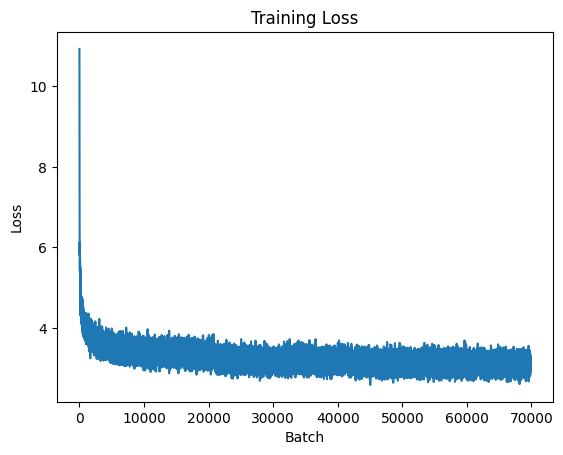

In [13]:
#plot loss over epochs
losses = [record["loss"] for record in training_history]
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

It appears that it shakily decreased throughout the training run.